In [1]:
from IPython.display import clear_output
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)
sns.set_palette(sns.color_palette("Set2"))
print(f"Running on {sys.version}")

Running on 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')
df_new = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')

In [3]:
LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != LABEL]
ORG_FEATS = df_train.drop(LABEL, axis=1).columns.tolist() # original feats

In [4]:
df_new.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df_train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [6]:
df_new.isnull().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [7]:
df_new.dtypes

ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [8]:
df_train.dtypes, df_train.isnull().sum()

(id                 int64
 N_Days             int64
 Drug              object
 Age                int64
 Sex               object
 Ascites           object
 Hepatomegaly      object
 Spiders           object
 Edema             object
 Bilirubin        float64
 Cholesterol      float64
 Albumin          float64
 Copper           float64
 Alk_Phos         float64
 SGOT             float64
 Tryglicerides    float64
 Platelets        float64
 Prothrombin      float64
 Stage            float64
 Status            object
 dtype: object,
 id               0
 N_Days           0
 Drug             0
 Age              0
 Sex              0
 Ascites          0
 Hepatomegaly     0
 Spiders          0
 Edema            0
 Bilirubin        0
 Cholesterol      0
 Albumin          0
 Copper           0
 Alk_Phos         0
 SGOT             0
 Tryglicerides    0
 Platelets        0
 Prothrombin      0
 Stage            0
 Status           0
 dtype: int64)

In [9]:
df_train2 = pd.concat([df_train, df_new], axis = 0, ignore_index = True)

In [10]:
df_train2.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,ID
count,7905.000000,8323.000000,8323.000000,8323.000000,8189.000000,8323.000000,8215.000000,8217.000000,8217.000000,8187.000000,8312.000000,8321.000000,8317.000000,418.000000
mean,3952.000000,2024.528776,18381.192359,2.625940,351.219074,3.545767,84.421546,1823.044883,114.906530,115.662636,264.827238,10.634575,3.032103,209.500000
std,2282.121272,1094.968696,3686.832308,3.847146,196.775246,0.350697,76.327480,1913.388685,49.134067,53.037660,88.039809,0.795707,0.867235,120.810458
min,0.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000,1.000000
25%,1976.000000,1220.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,210.000000,10.000000,2.000000,105.250000
50%,3952.000000,1831.000000,18713.000000,1.100000,299.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,264.000000,10.600000,3.000000,209.500000
75%,5928.000000,2689.000000,20684.000000,3.000000,392.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000,313.750000
max,7904.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000,418.000000


In [11]:
df_train2.shape

(8323, 21)

In [12]:
df_train2.isnull().sum()

id                418
N_Days              0
Drug              106
Age                 0
Sex                 0
Ascites           106
Hepatomegaly      106
Spiders           106
Edema               0
Bilirubin           0
Cholesterol       134
Albumin             0
Copper            108
Alk_Phos          106
SGOT              106
Tryglicerides     136
Platelets          11
Prothrombin         2
Stage               6
Status              0
ID               7905
dtype: int64

In [13]:
df_train.shape, df_test.shape, df_sub.shape, df_train2.shape

((7905, 20), (5271, 19), (5271, 4), (8323, 21))

In [14]:
df_train2.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status', 'ID'],
      dtype='object')

In [15]:
df_train2 = df_train2.drop(["id", "ID"], axis = 1)
df_test = df_test.drop(["id"], axis = 1)

In [16]:
df_train2.dtypes, df_train2.isnull().sum()

(N_Days             int64
 Drug              object
 Age                int64
 Sex               object
 Ascites           object
 Hepatomegaly      object
 Spiders           object
 Edema             object
 Bilirubin        float64
 Cholesterol      float64
 Albumin          float64
 Copper           float64
 Alk_Phos         float64
 SGOT             float64
 Tryglicerides    float64
 Platelets        float64
 Prothrombin      float64
 Stage            float64
 Status            object
 dtype: object,
 N_Days             0
 Drug             106
 Age                0
 Sex                0
 Ascites          106
 Hepatomegaly     106
 Spiders          106
 Edema              0
 Bilirubin          0
 Cholesterol      134
 Albumin            0
 Copper           108
 Alk_Phos         106
 SGOT             106
 Tryglicerides    136
 Platelets         11
 Prothrombin        2
 Stage              6
 Status             0
 dtype: int64)

In [17]:
missing_values = df_train2.isnull().sum()

numerical_columns = df_train2.select_dtypes(include=['number']).columns
categorical_columns = df_train2.select_dtypes(include=['object', 'category']).columns

missing_numerical = missing_values[numerical_columns]
missing_categorical = missing_values[categorical_columns]

print("Numerical columns with missing values:")
print(missing_numerical[missing_numerical > 0])

print("\nCategorical columns with missing values:")
print(missing_categorical[missing_categorical > 0])

Numerical columns with missing values:
Cholesterol      134
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

Categorical columns with missing values:
Drug            106
Ascites         106
Hepatomegaly    106
Spiders         106
dtype: int64


In [18]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

numerical_columns = df_train2.select_dtypes(include=['number']).columns
categorical_columns = df_train2.select_dtypes(include=['object', 'category']).columns

knn_imputer = KNNImputer()
df_train2[numerical_columns] = knn_imputer.fit_transform(df_train2[numerical_columns])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df_train2[categorical_columns] = categorical_imputer.fit_transform(df_train2[categorical_columns])

**PieChart**

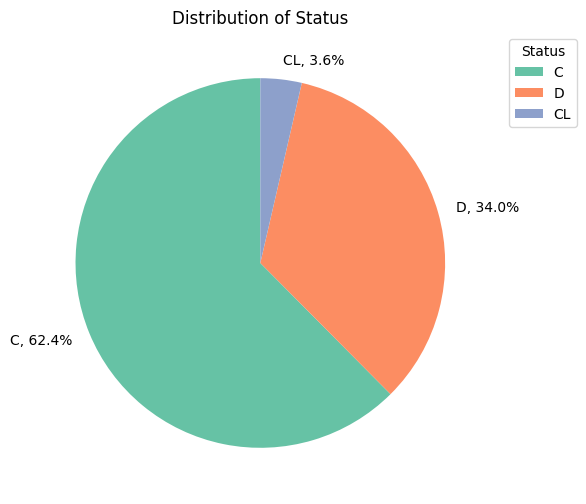

In [19]:
status_counts = df_train2[LABEL].value_counts()
labels = status_counts.index
sizes = status_counts.values

percentages = 100.*sizes/sizes.sum()

plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=[f"{l}, {s:.1f}%" for l, s in zip(labels, percentages)], startangle=90)
plt.gca().set_aspect("equal")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), labels=labels, title=LABEL)
plt.title(f"Distribution of {LABEL}")
plt.show()

**ViolinPlots**

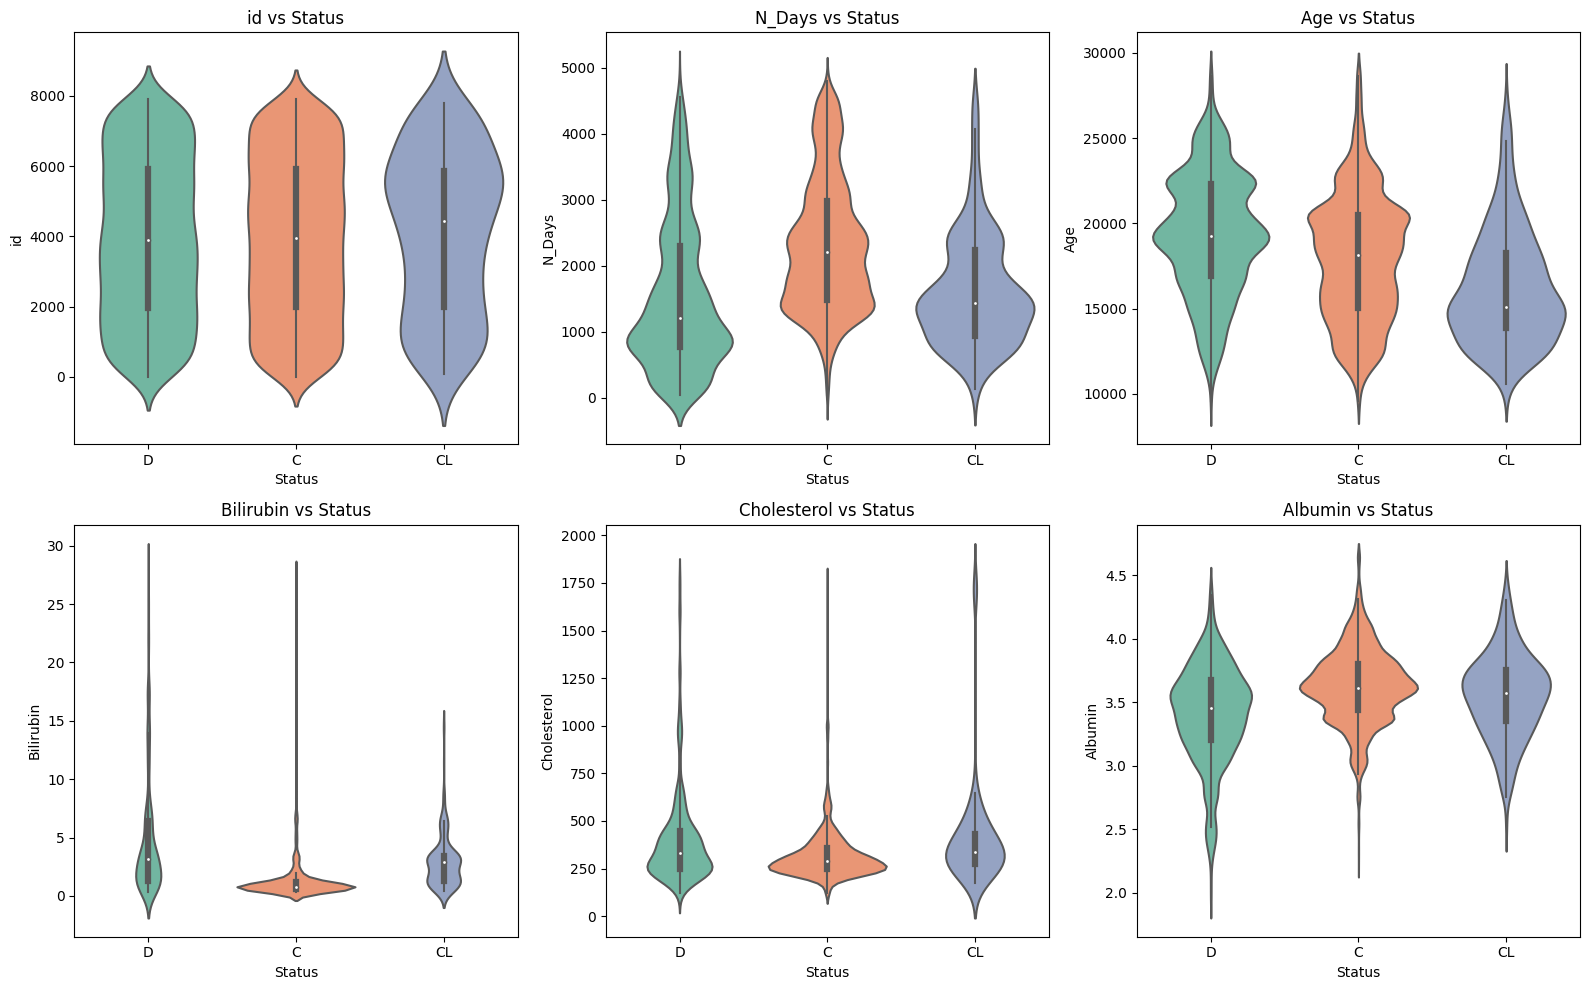

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, ax in enumerate(axes.flatten()):
    sns.violinplot(x=LABEL, y=NUM_FEATS[i], data=df_train, ax=ax)
    ax.set_title(f"{NUM_FEATS[i]} vs {LABEL}")
plt.tight_layout()
plt.show()

**Heatmap**

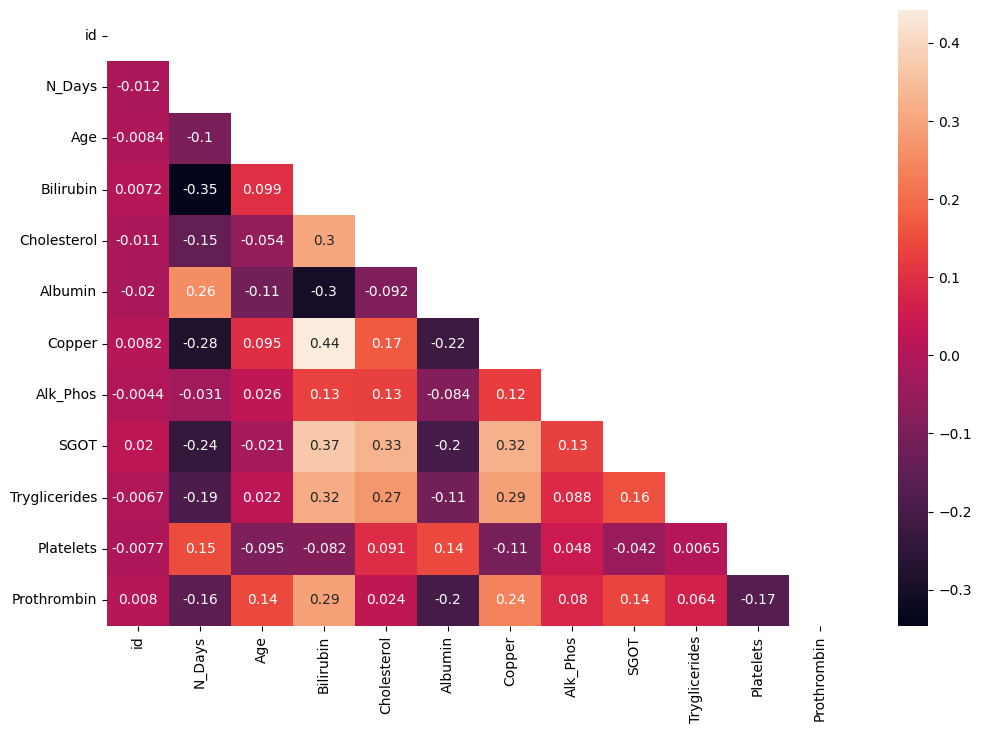

In [21]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_train[NUM_FEATS].corr(), dtype=bool))
sns.heatmap(df_train[NUM_FEATS].corr(), annot=True, mask=mask)
plt.show()

**PairPlot**

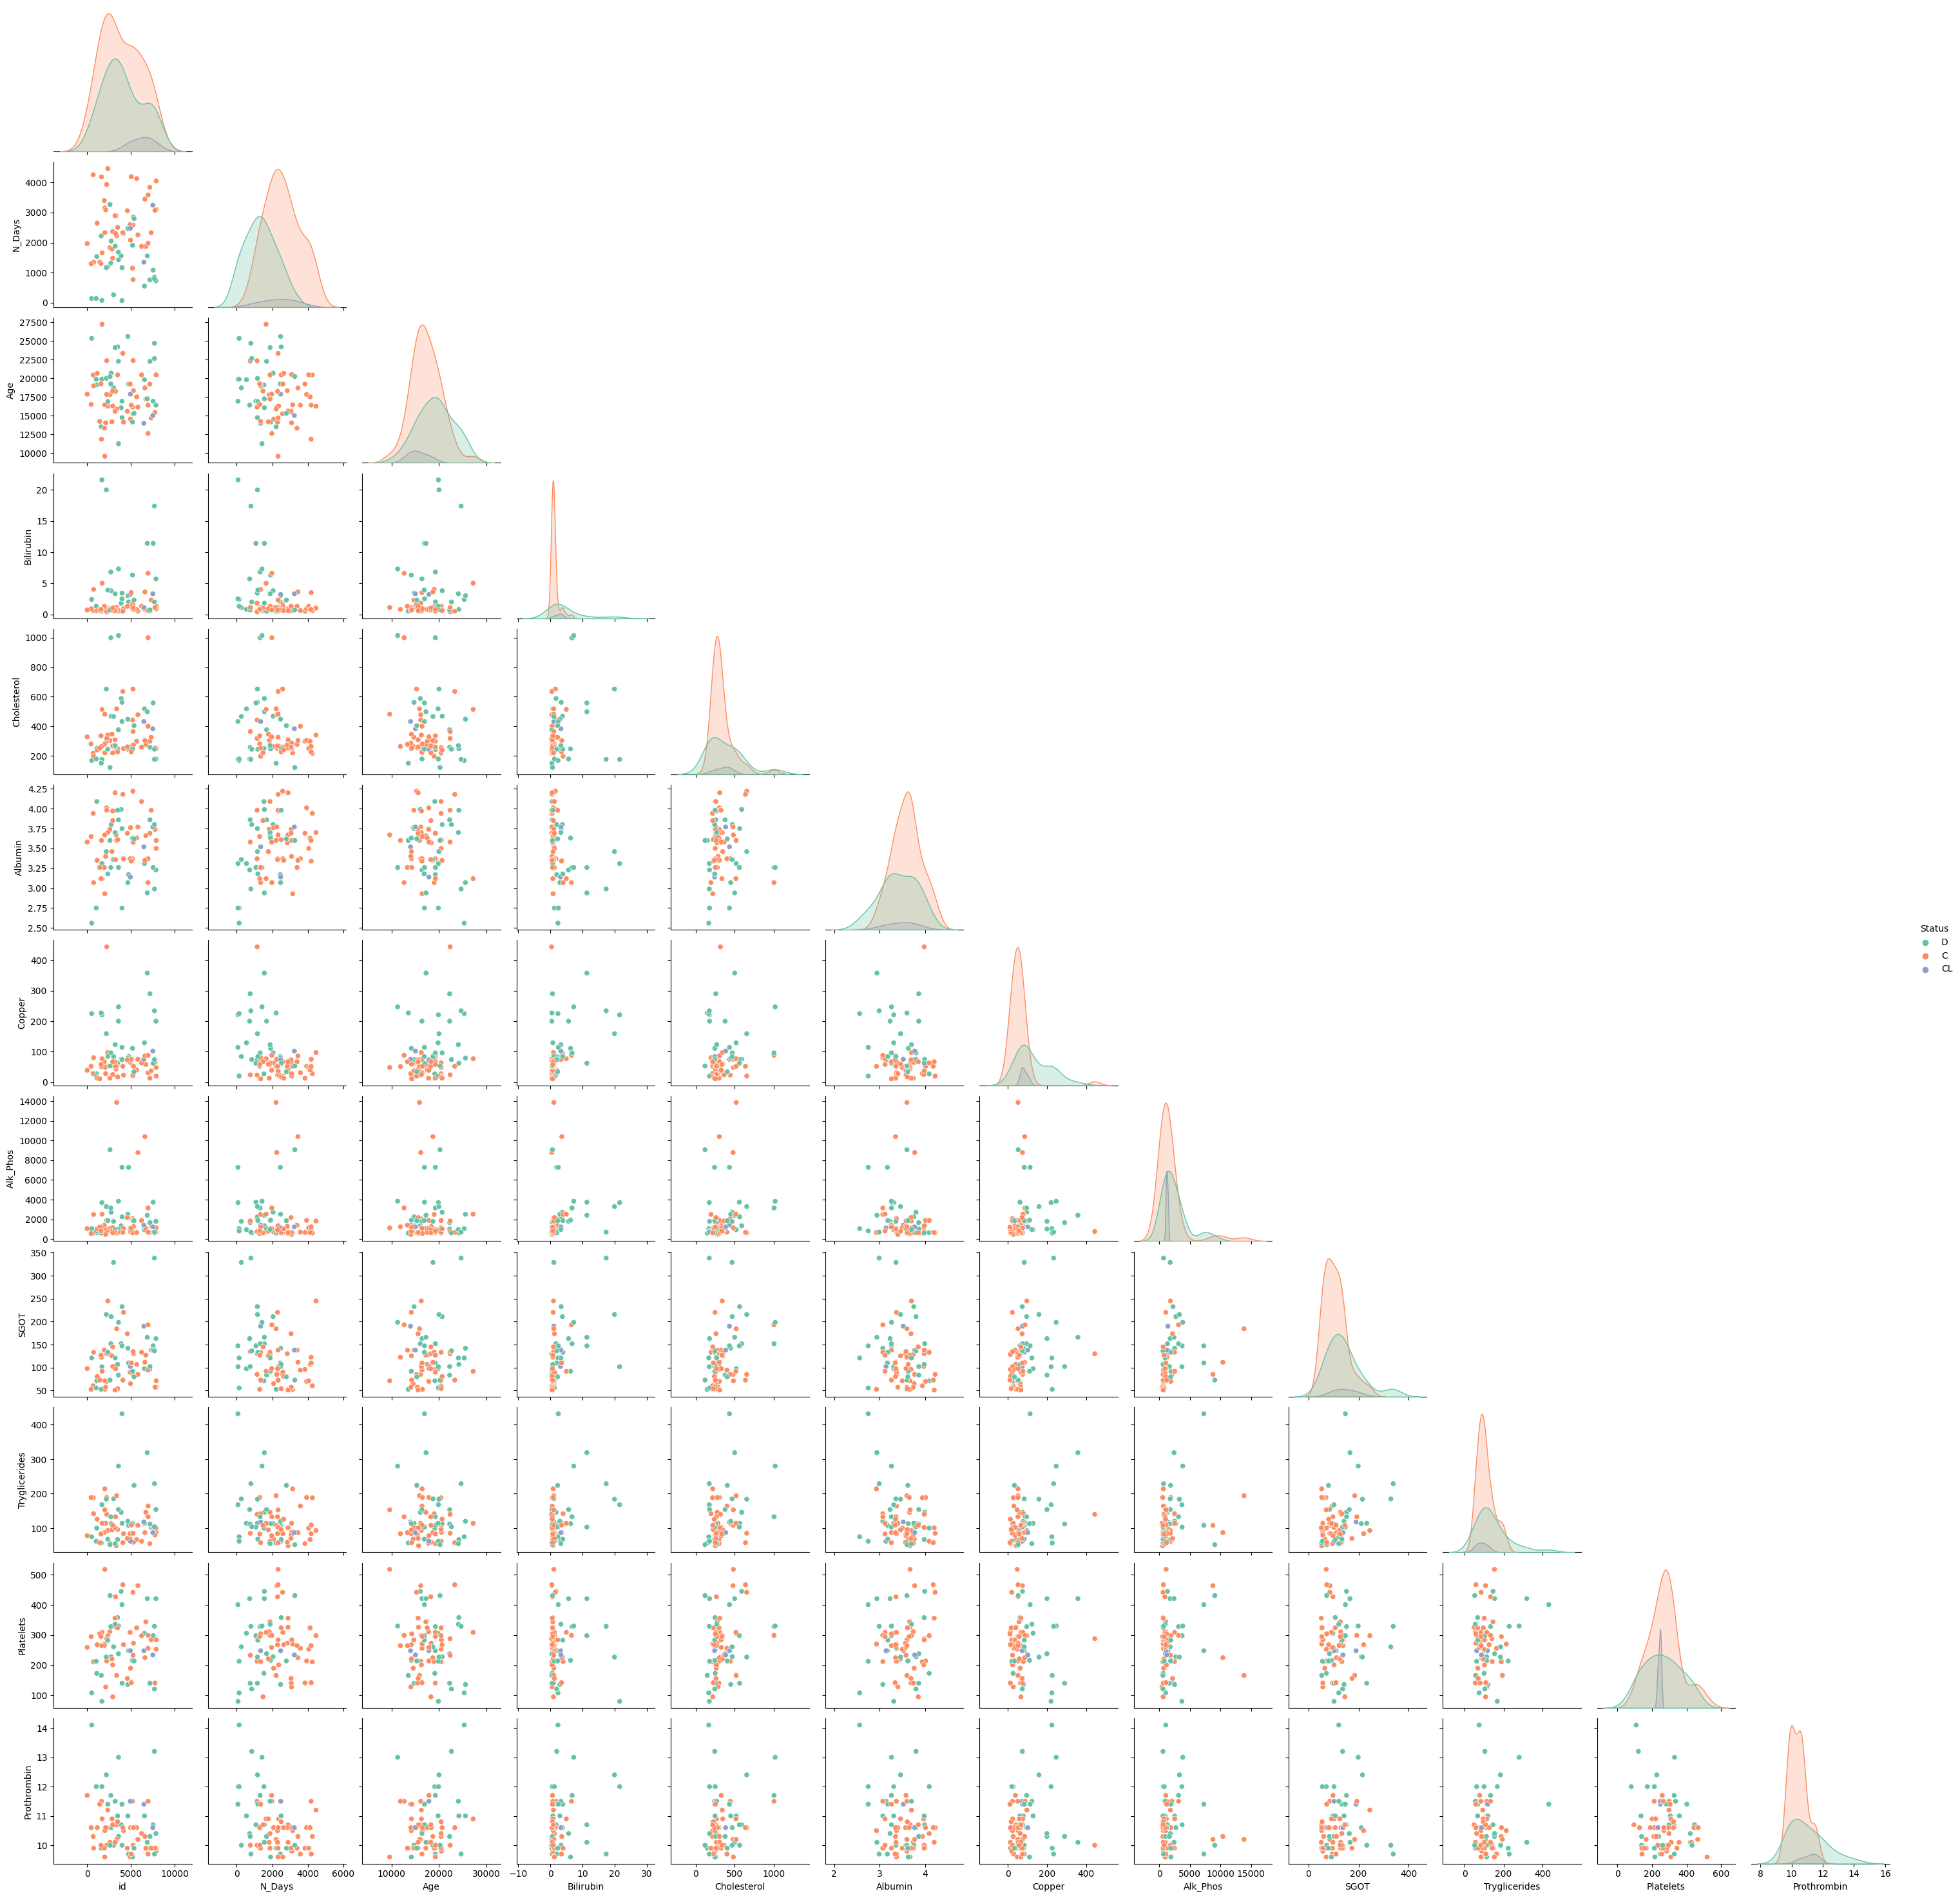

In [22]:
pairplot = sns.pairplot(df_train[NUM_FEATS + [LABEL]].sample(frac=.01), 
                 hue=LABEL, 
                 corner=True)

**SweetViz**

In [23]:
!pip install sweetviz

  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/89/50/8d3f7ca820267a38b42c64778db0f186d85cec6e3f0c5210eab9c16e783f/sweetviz-2.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 38.0 MB/s eta 0:00:0000:0100:01


                                             |          | [  0%]   00:00 -> (? left)


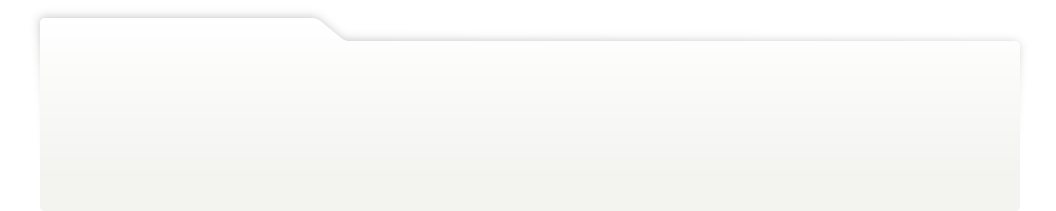
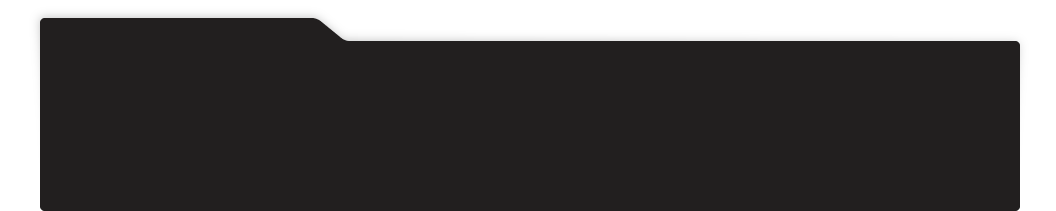
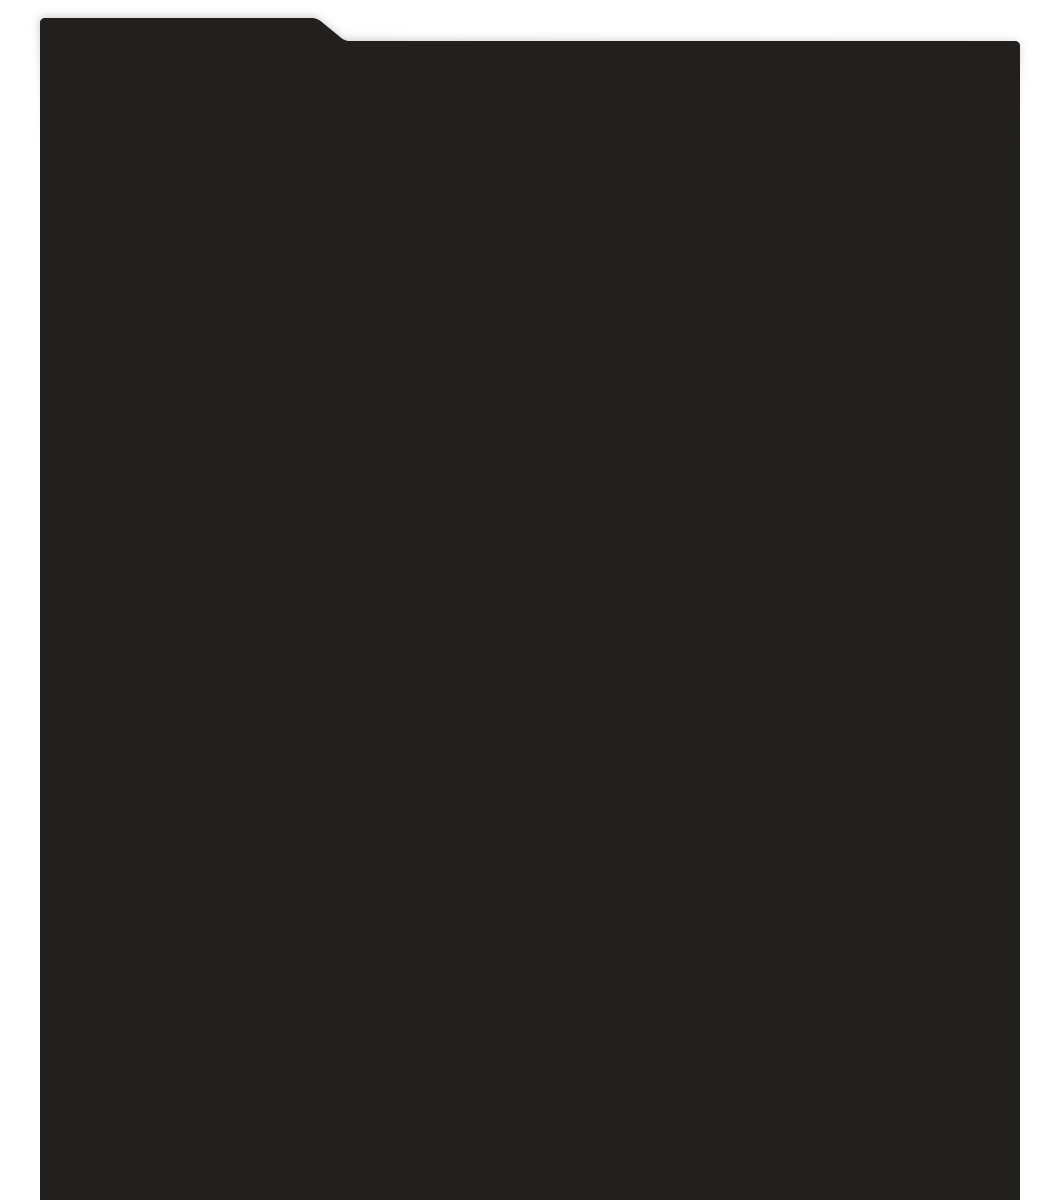
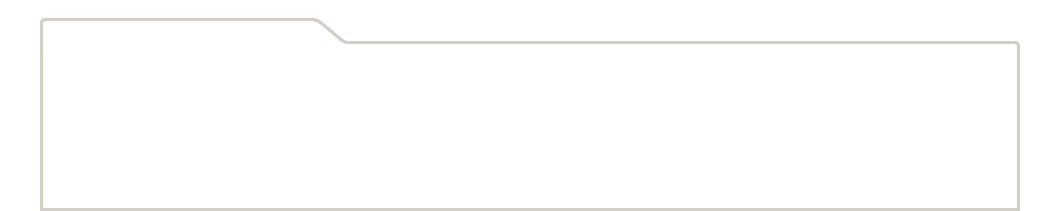
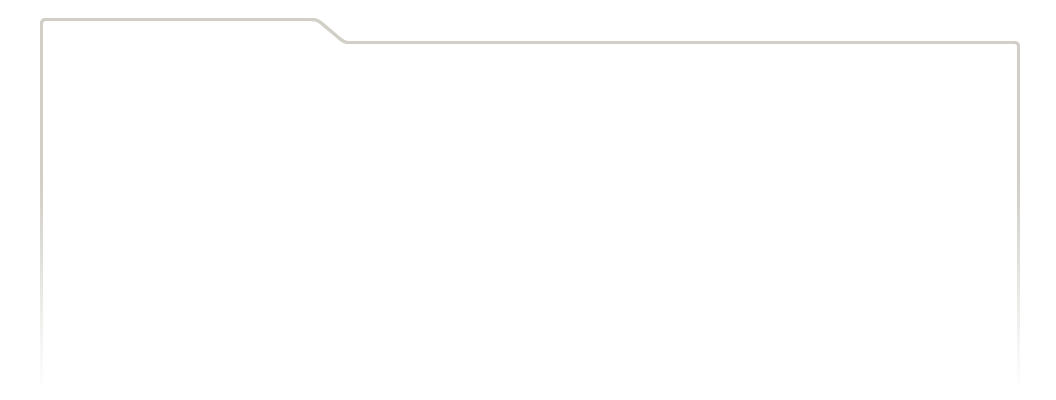
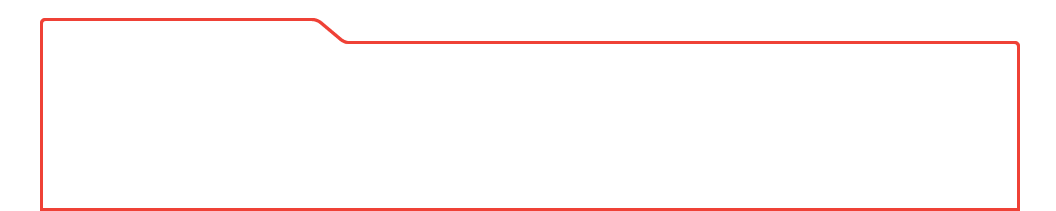
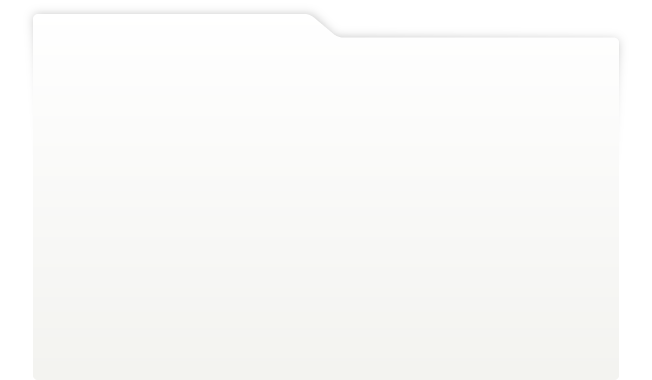
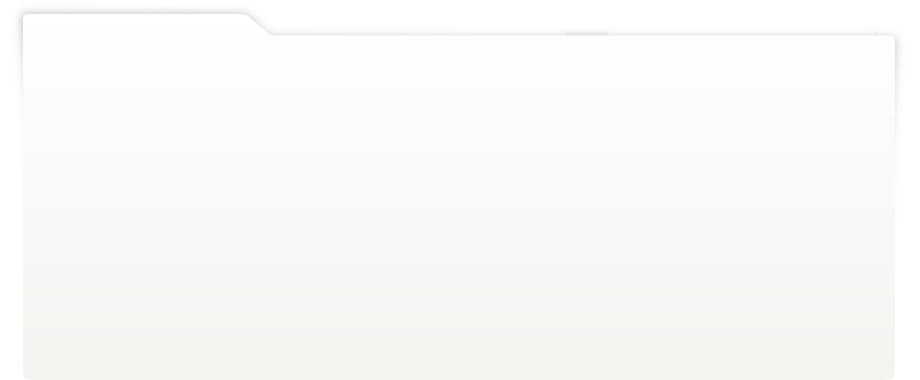
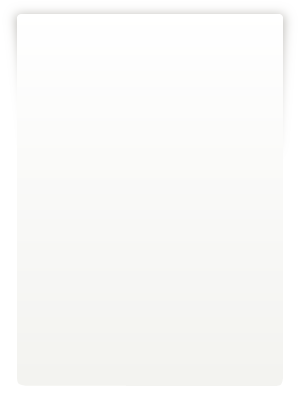
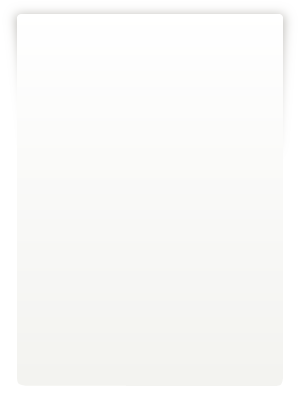
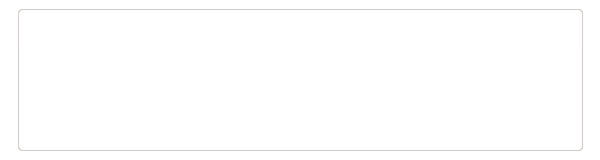
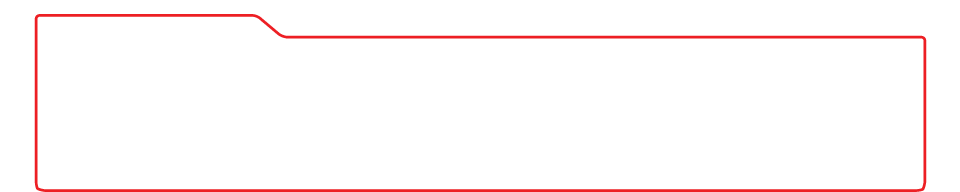
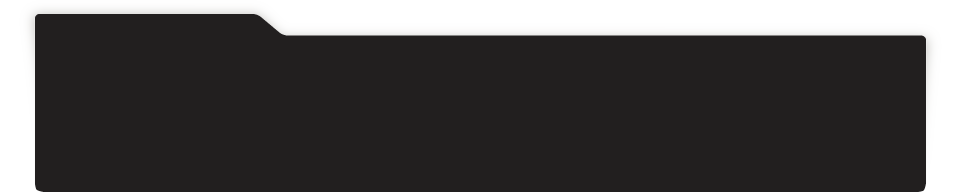
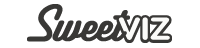
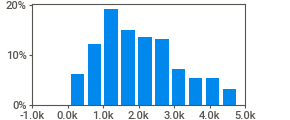
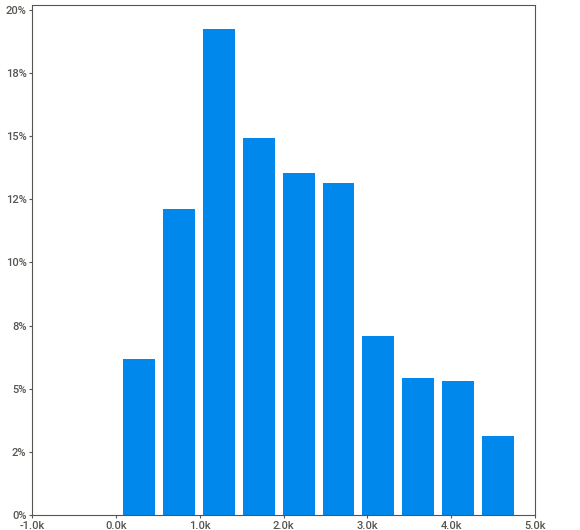
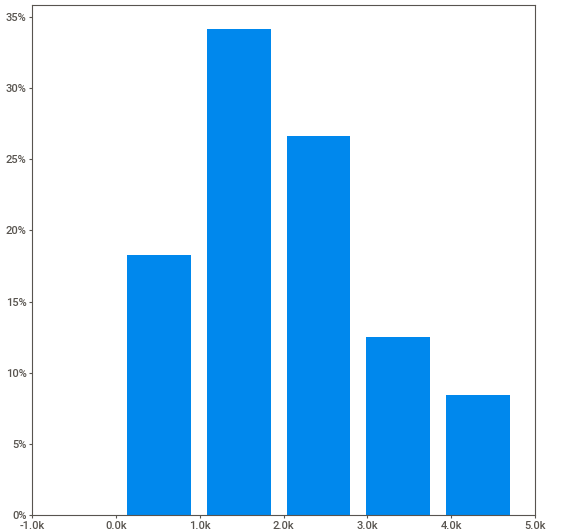
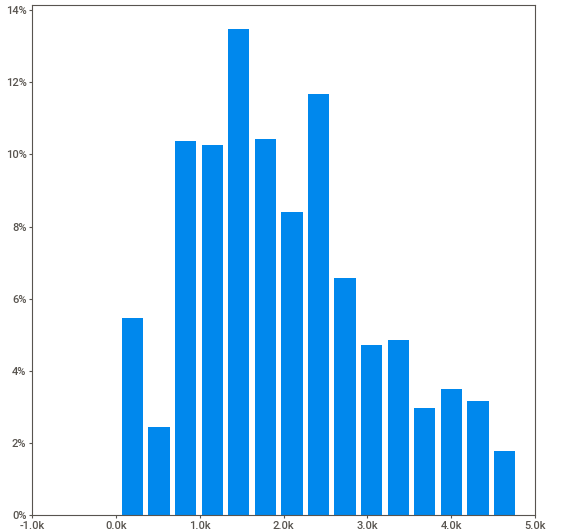
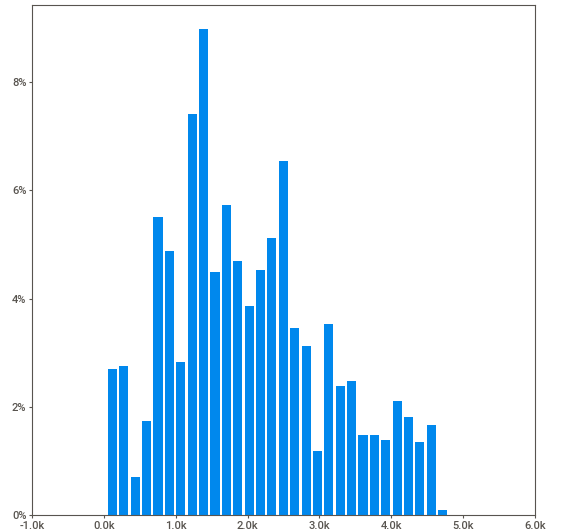
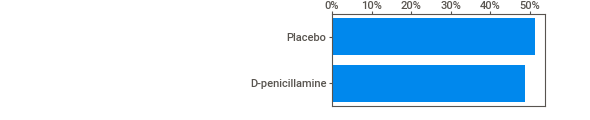
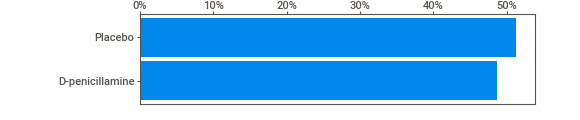
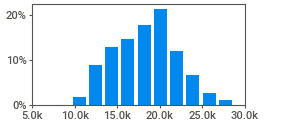
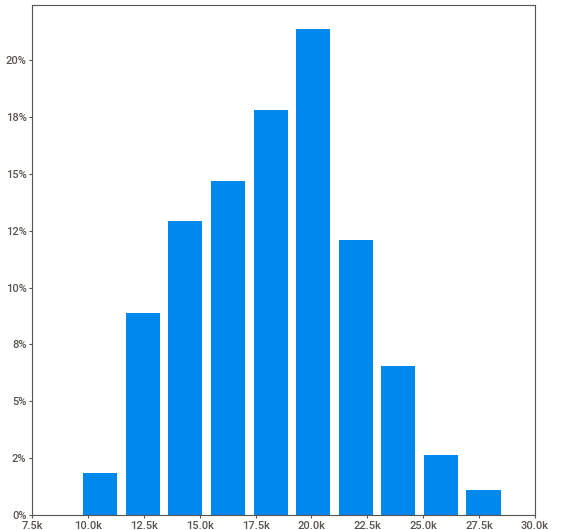
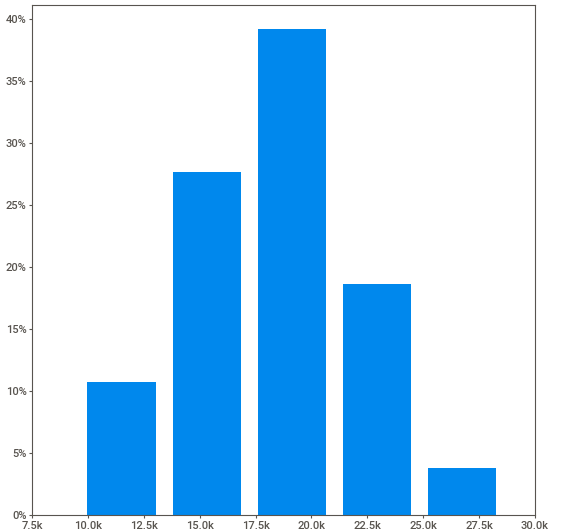
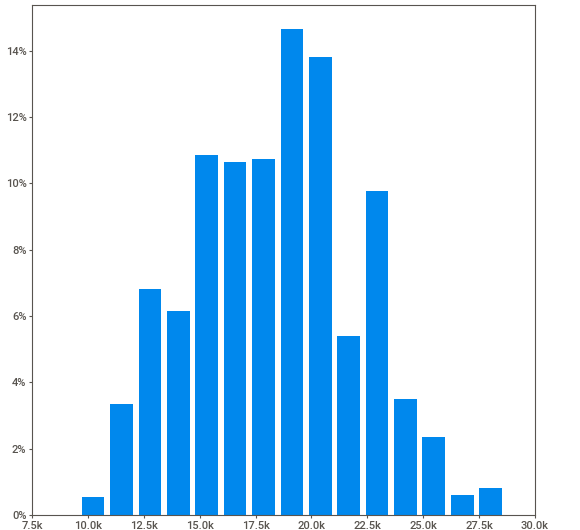
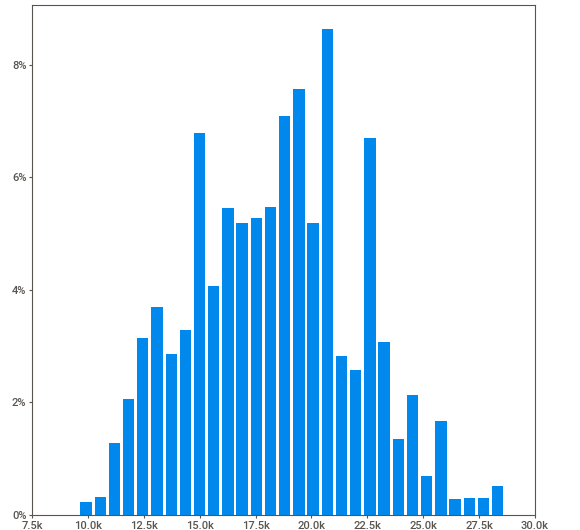
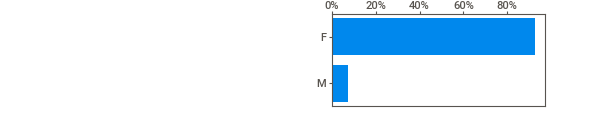
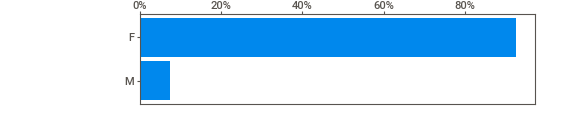
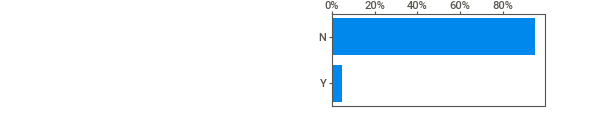
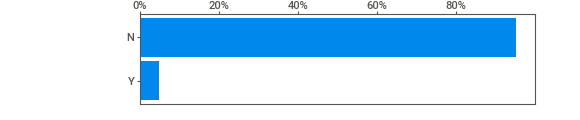
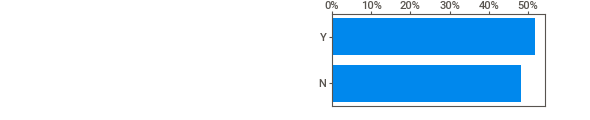
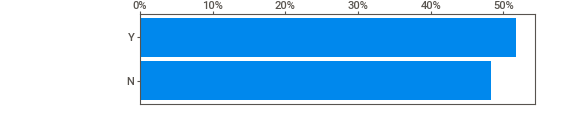
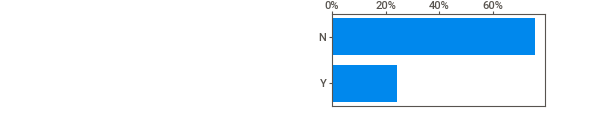
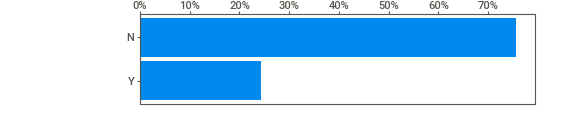
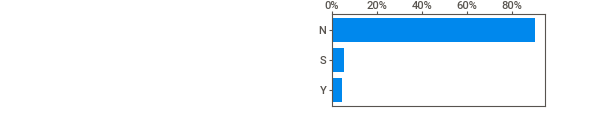
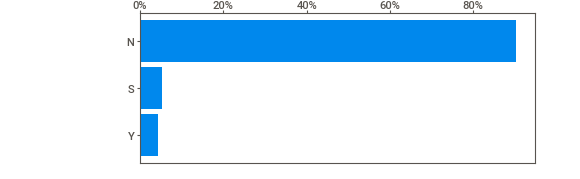
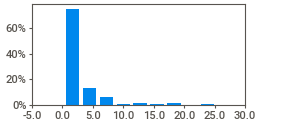
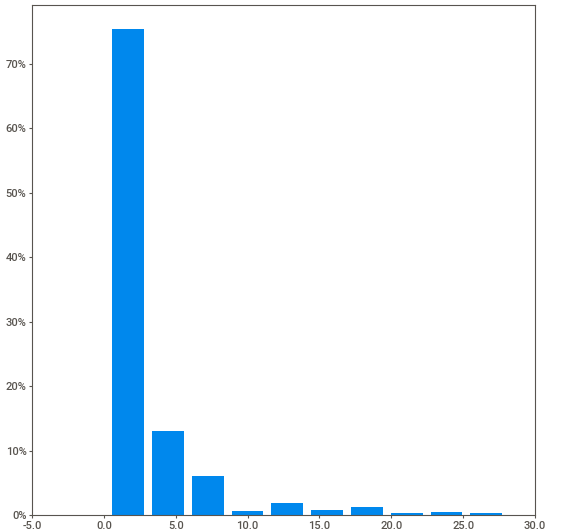
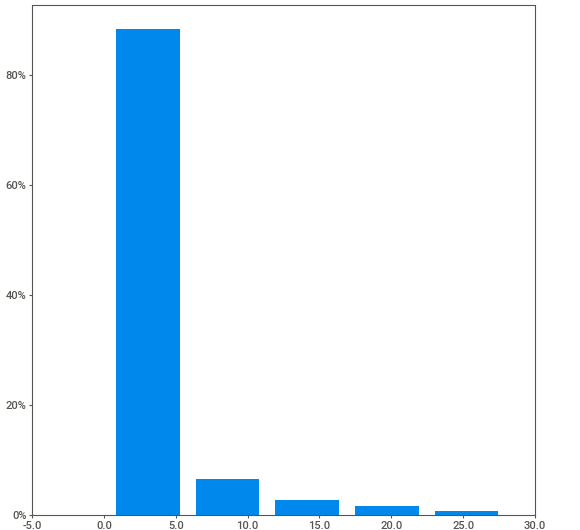
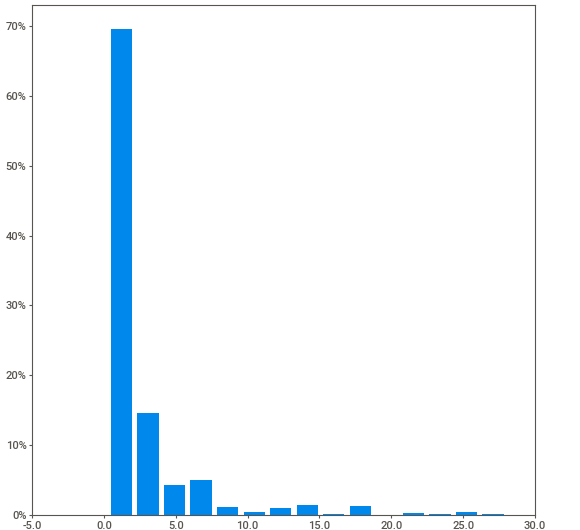
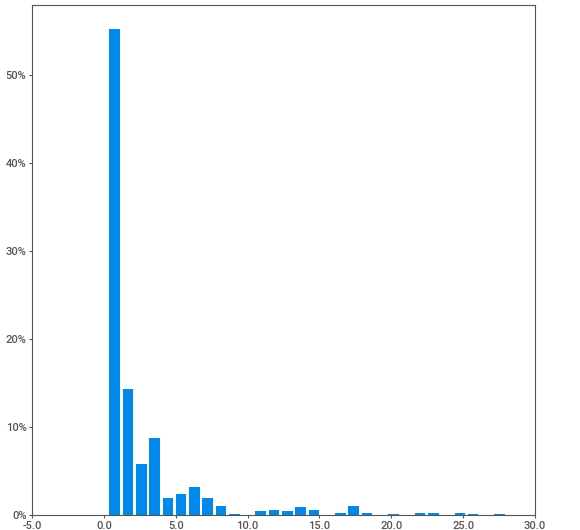
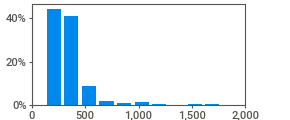
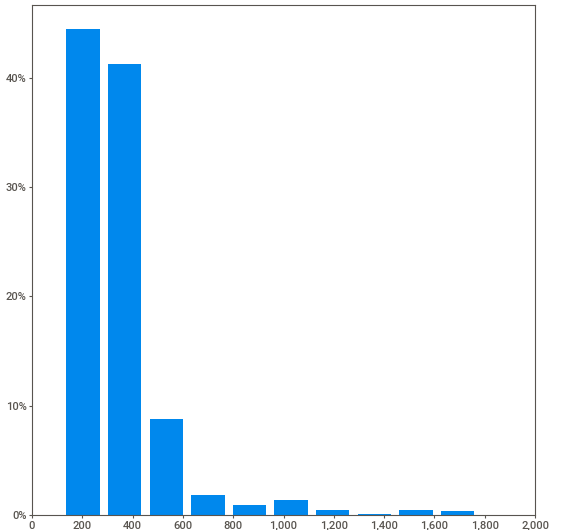
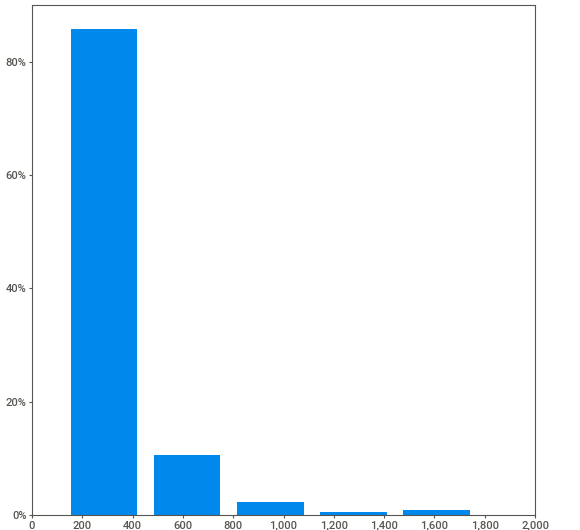
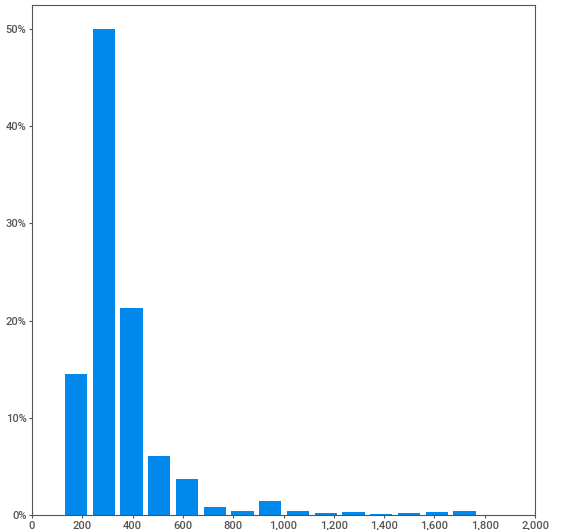
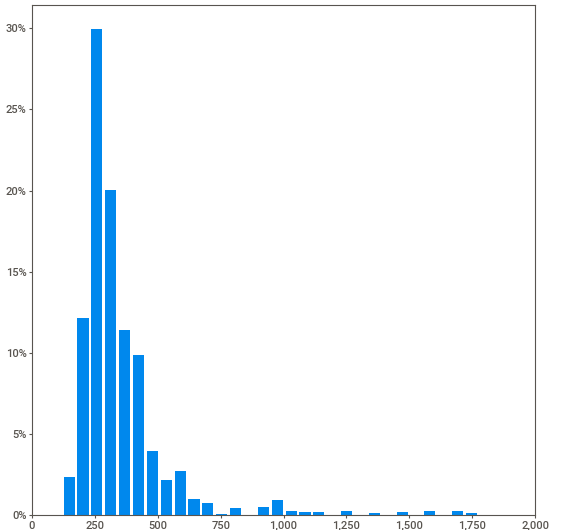
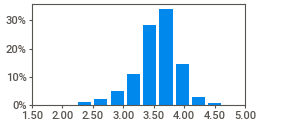
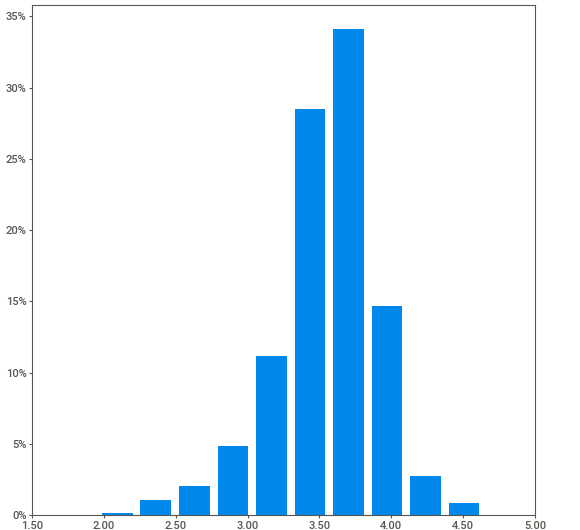
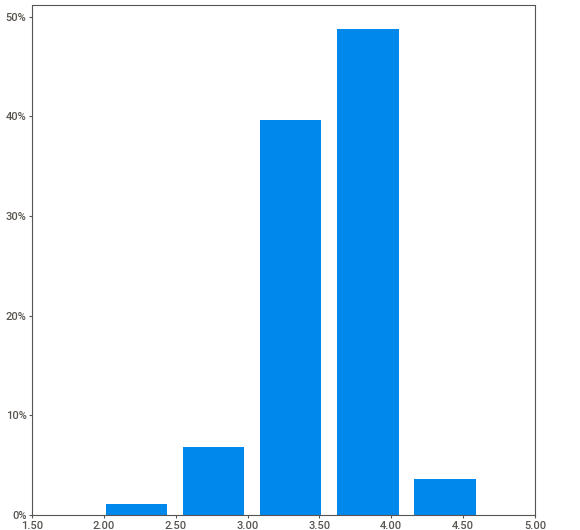
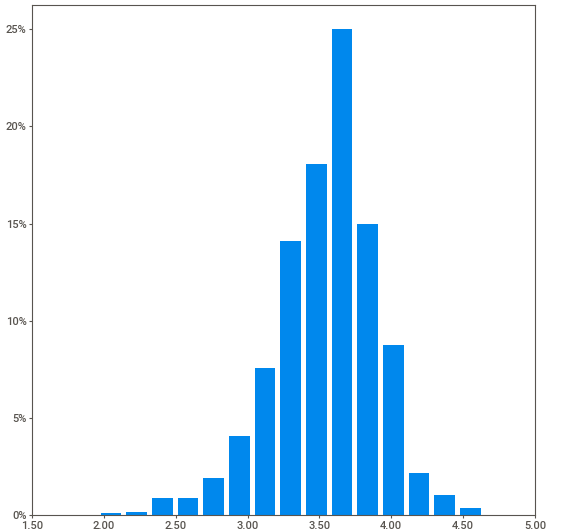
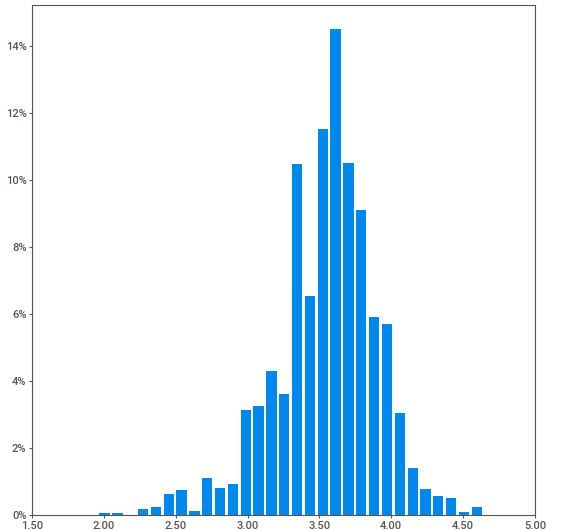
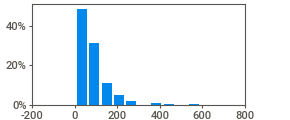
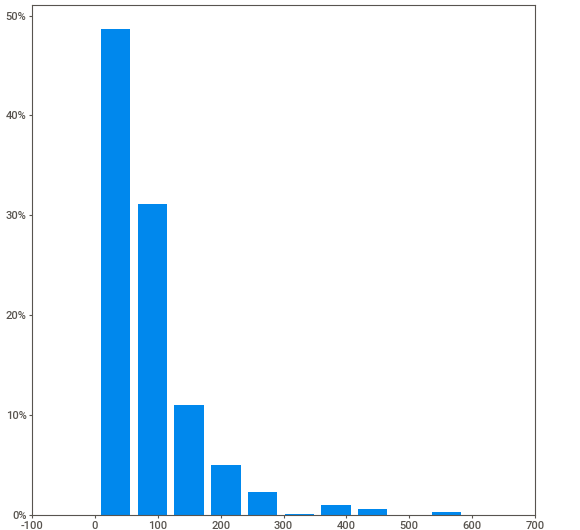
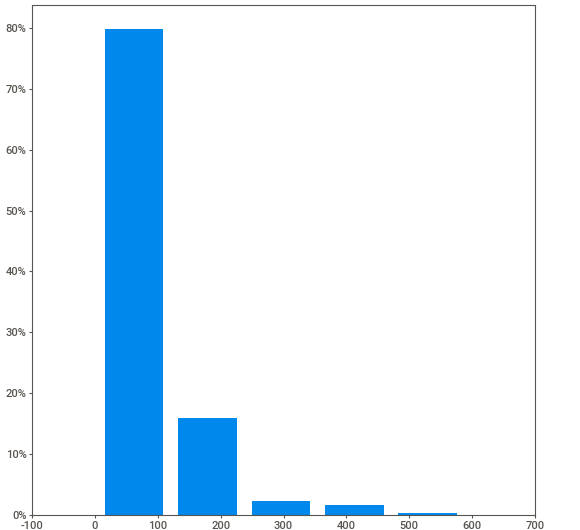
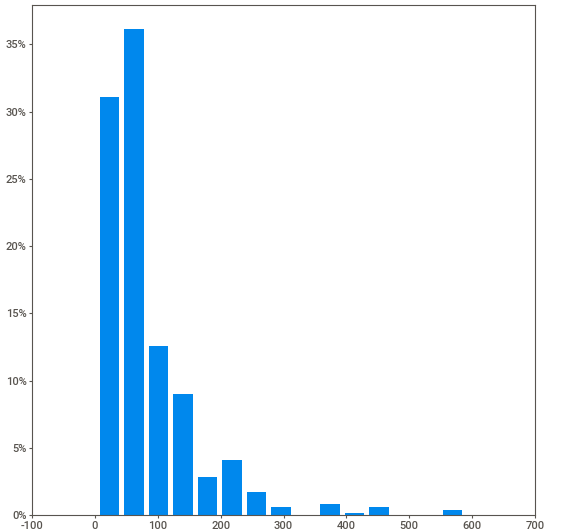
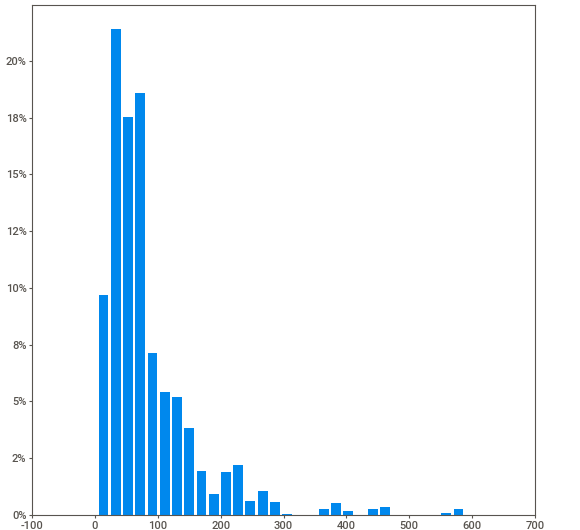
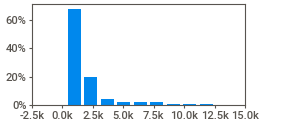
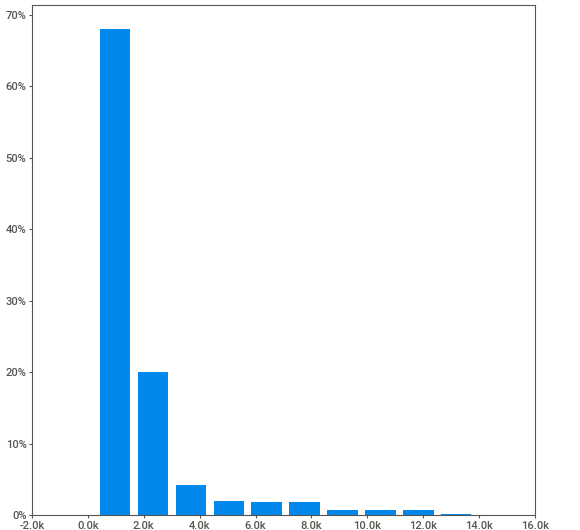
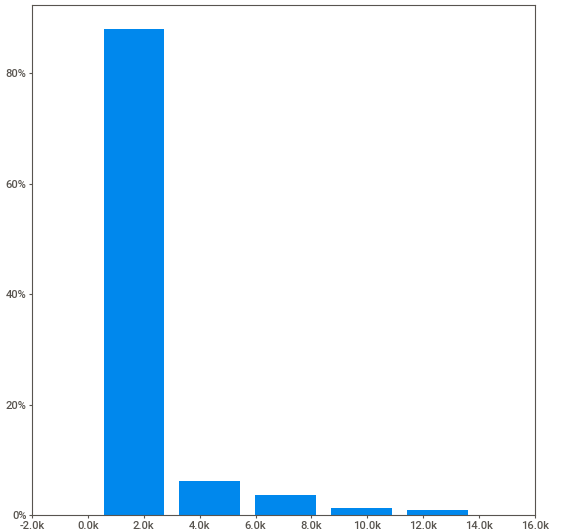
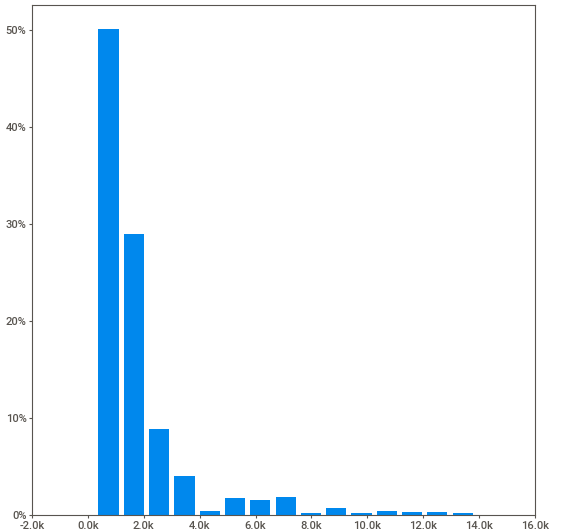
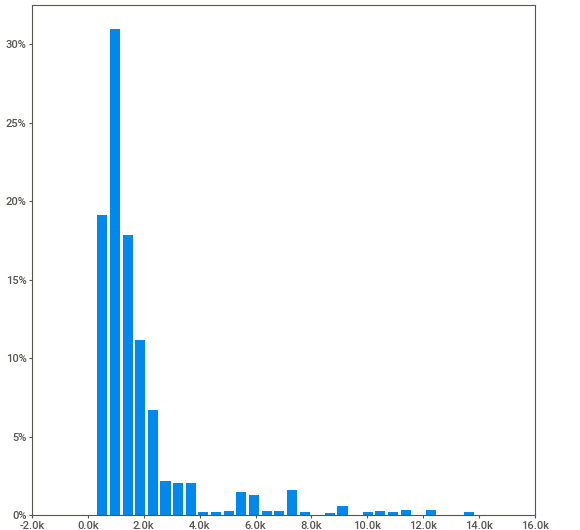
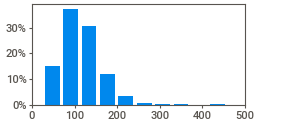
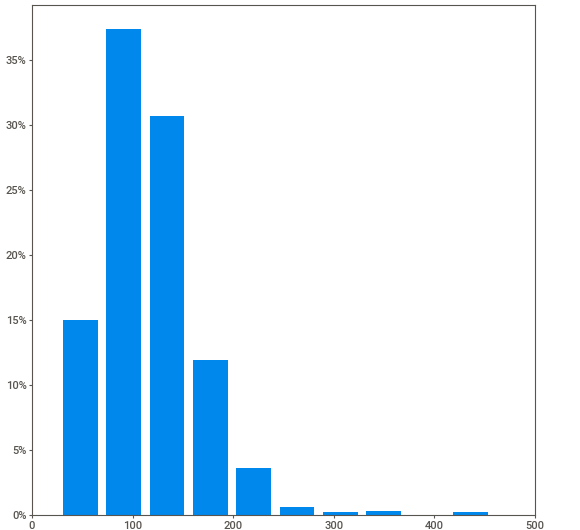
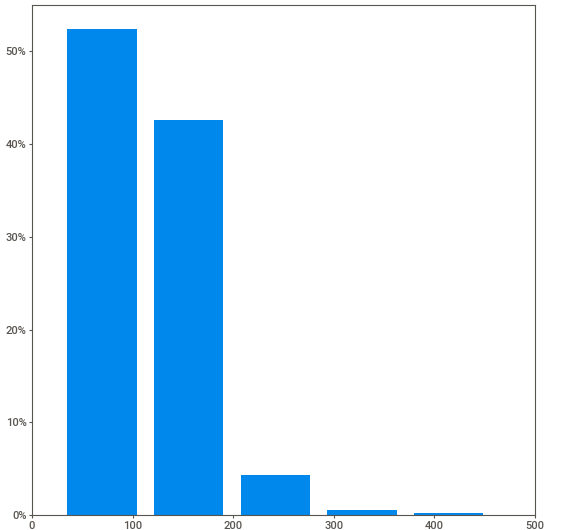
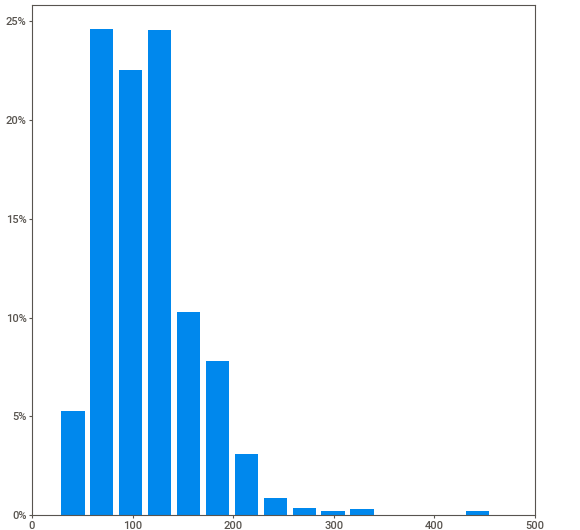
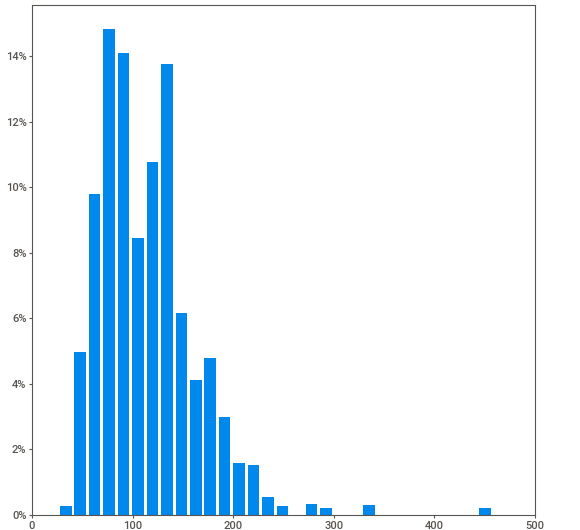
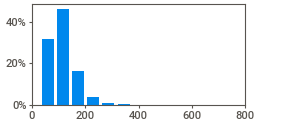
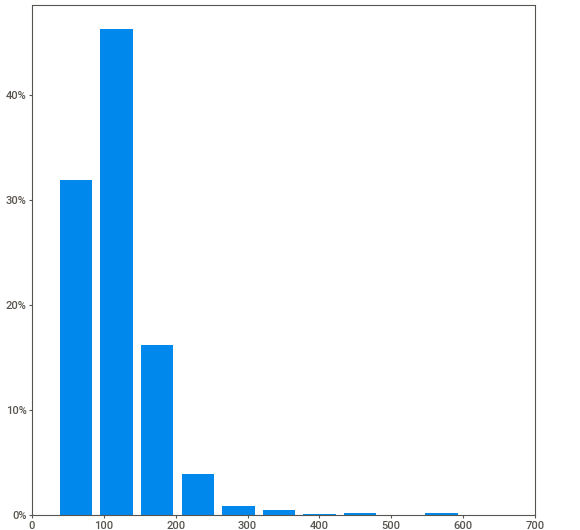
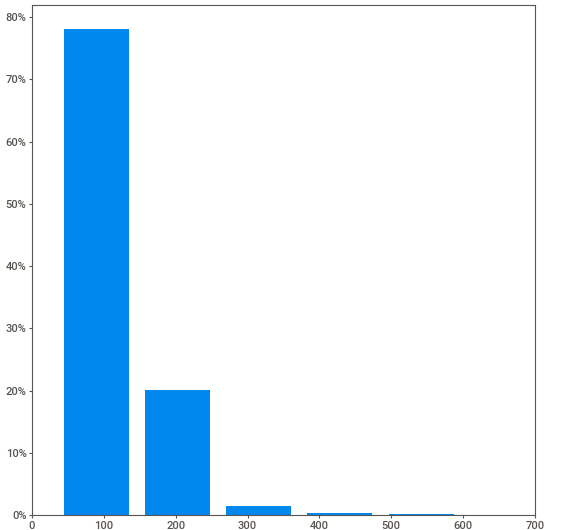
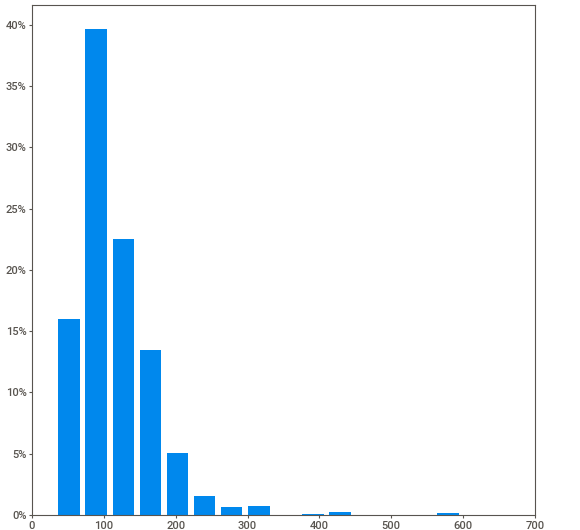
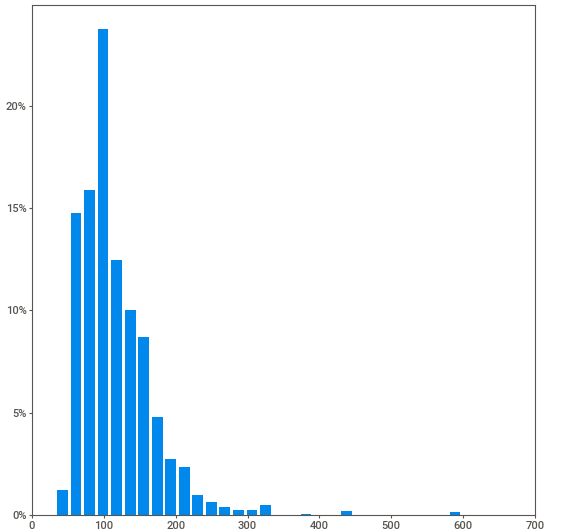
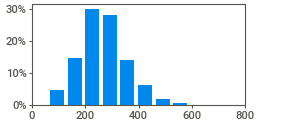
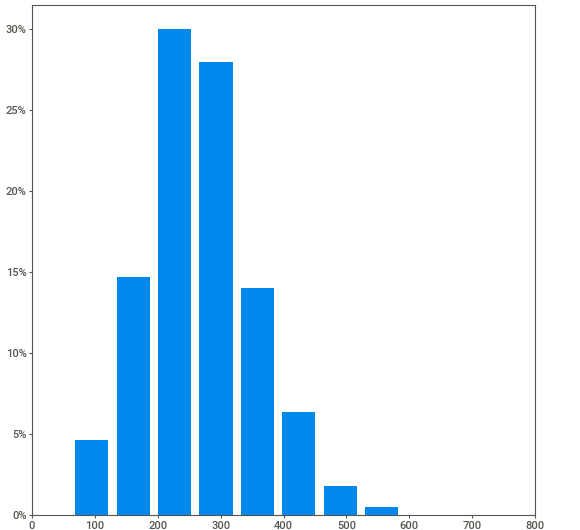
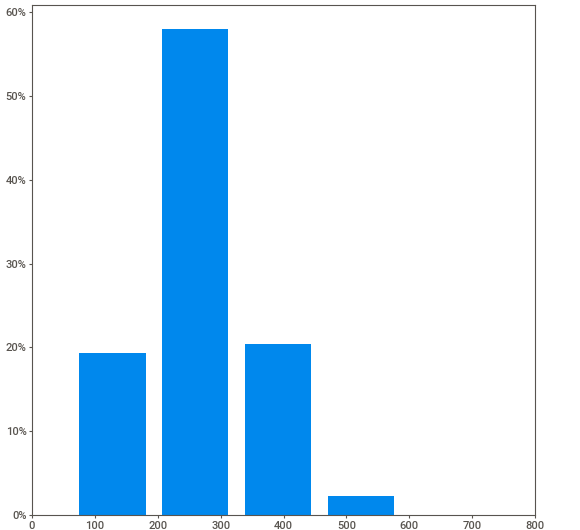
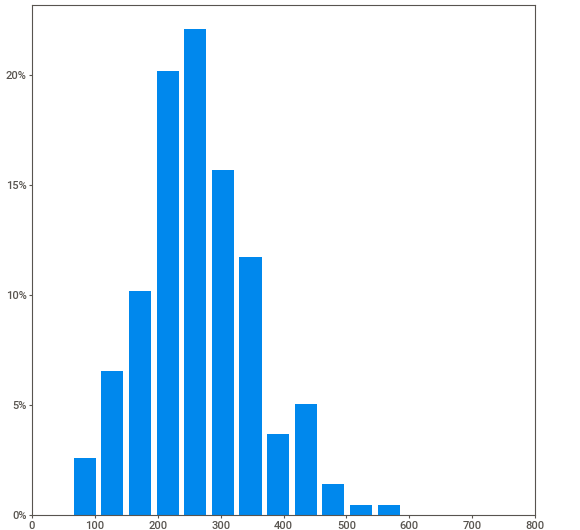
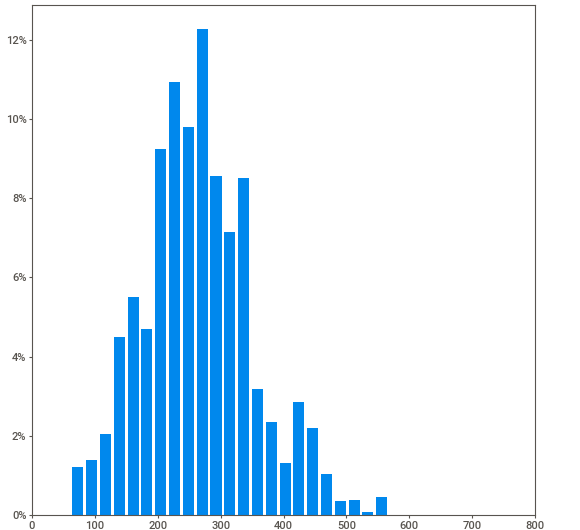
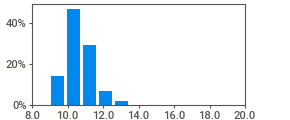
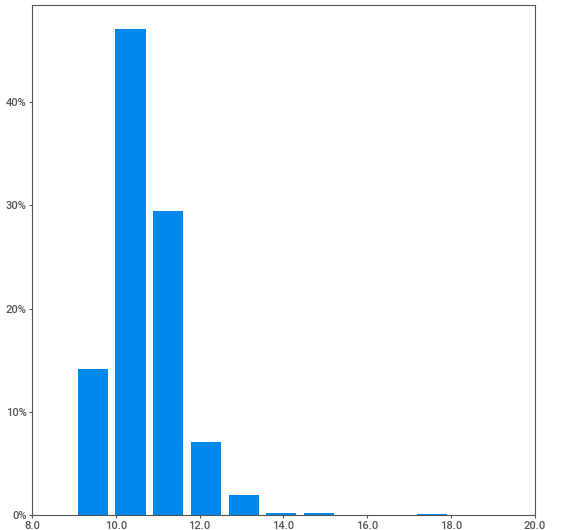
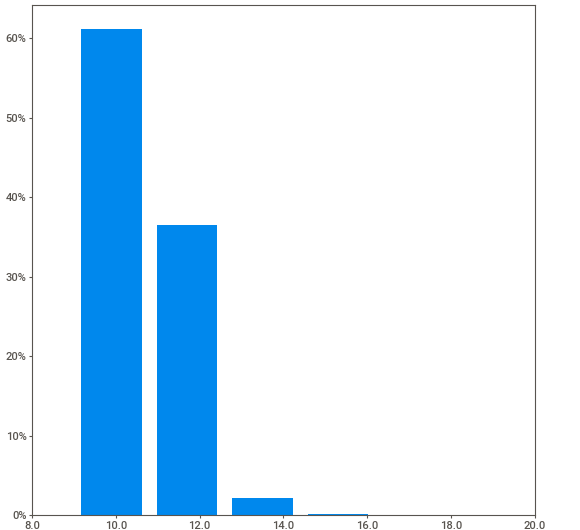
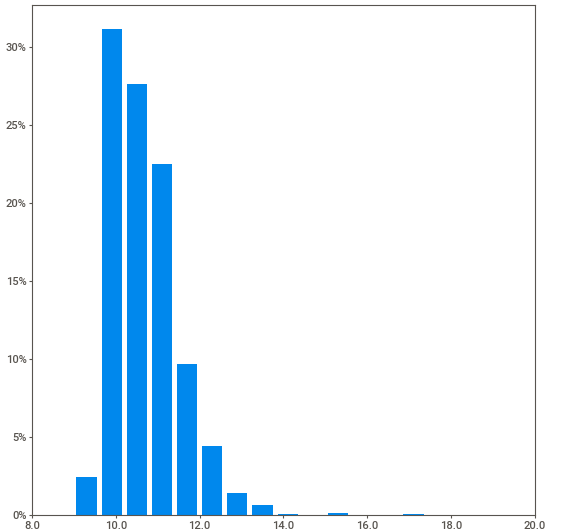
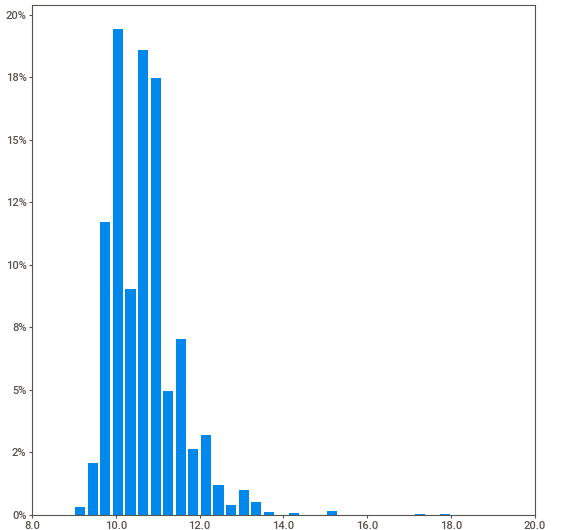
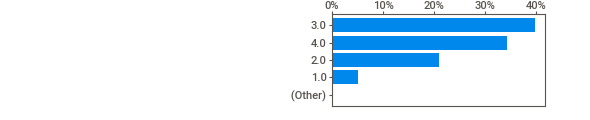
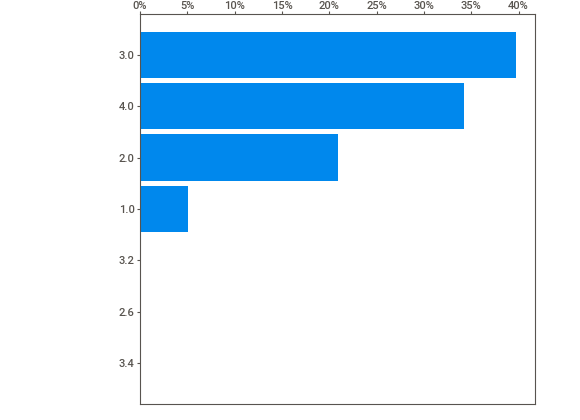
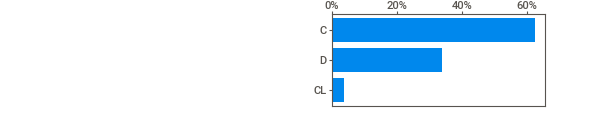
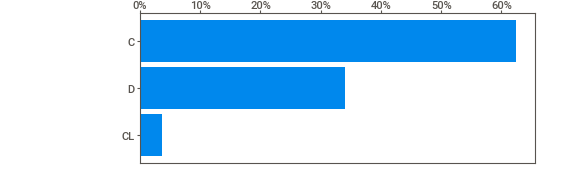
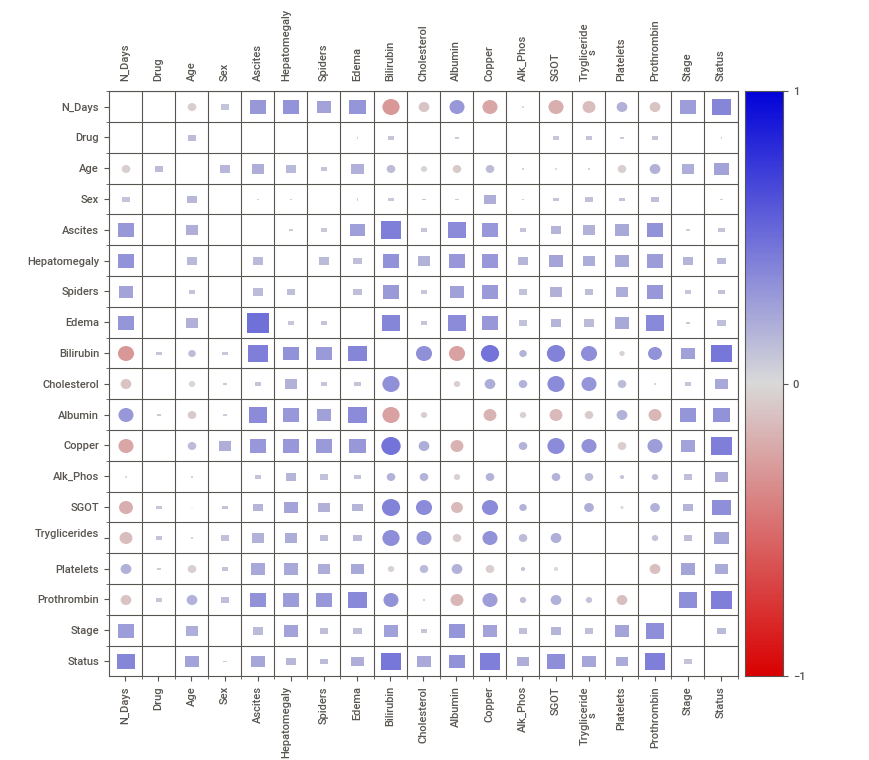
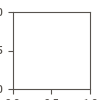

In [24]:
import sweetviz 

my_report = sweetviz.analyze([df_train2, "Train"])
my_report.show_notebook(w="100%", h="full")

In [25]:
df_train2['Status'].value_counts()

Status
C     5197
D     2826
CL     300
Name: count, dtype: int64

In [26]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

n_folds = 5
repeats = 3

In [27]:
from sklearn.preprocessing import LabelEncoder

object_columns = df_train2.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

for col in object_columns:
    df_train2[col] = label_encoder.fit_transform(df_train2[col])

object_columns1 = df_test.select_dtypes(include=['object']).columns
for col1 in object_columns1:
    df_test[col1] = label_encoder.fit_transform(df_test[col1])

In [28]:
df_test

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,0,19724,0,0,1,0,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,0,14975,0,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,1,13149,0,0,1,0,2,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,0,20510,0,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,0,21904,0,0,1,0,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,2870,1,12279,0,0,0,0,0,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0
5267,1770,1,24803,0,0,0,0,0,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0
5268,3707,0,16990,0,0,1,0,0,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0
5269,1216,1,11773,0,0,0,0,0,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0


In [29]:
X = df_train2
X

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999.0,0,21532.0,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.00,179.800,63.0,394.0,9.7,3.0,2
1,2574.0,1,19237.0,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.00,134.850,88.0,361.0,11.0,3.0,0
2,3428.0,1,13727.0,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.00,119.350,50.0,199.0,11.7,4.0,2
3,2576.0,1,18460.0,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.00,71.300,96.0,269.0,10.7,3.0,0
4,788.0,1,16658.0,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.00,125.550,96.0,298.0,10.6,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,681.0,1,24472.0,0,0,1,0,0,1.2,689.4,2.96,146.0,3555.72,157.480,126.8,174.0,10.9,3.0,2
8319,1103.0,1,14245.0,0,0,1,0,0,0.9,297.6,3.83,100.2,3292.64,109.530,113.4,180.0,11.2,4.0,0
8320,1055.0,1,20819.0,0,0,1,0,0,1.6,270.4,3.42,73.2,2610.60,122.524,85.6,143.0,9.9,3.0,0
8321,691.0,1,21185.0,0,0,1,0,0,0.8,246.0,3.75,97.8,1120.60,113.240,96.8,269.0,10.4,3.0,0


**FeatureEngineering**

In [30]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])

        # Drop the original symptom columns and add the new encoded features
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer())
])

df_train2 = pipeline.fit_transform(df_train2)
df_test = pipeline.transform(df_test)

In [31]:
y = df_train2['Status'] 
df_train2 = df_train2.drop(['Status'],axis=1)
X = df_train2 

In [32]:
X

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_0000,Symptom_Score_0001,Symptom_Score_0002,Symptom_Score_0010,Symptom_Score_0011,Symptom_Score_0012,Symptom_Score_0100,Symptom_Score_0101,Symptom_Score_0102,Symptom_Score_0110,Symptom_Score_0111,Symptom_Score_0112,Symptom_Score_1000,Symptom_Score_1001,Symptom_Score_1002,Symptom_Score_1010,Symptom_Score_1011,Symptom_Score_1012,Symptom_Score_1100,Symptom_Score_1101,Symptom_Score_1102,Symptom_Score_1110,Symptom_Score_1111,Symptom_Score_1112,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
0,999.0,0,21532.0,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.00,179.800,63.0,394.0,9.7,3.0,20533.0,59,2,7.705,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446.6125,-1595.35,2,8
1,2574.0,1,19237.0,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.00,134.850,88.0,361.0,11.0,3.0,16663.0,53,2,3.186,0.9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,394.8225,-1435.56,7,0
2,3428.0,1,13727.0,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.00,119.350,50.0,199.0,11.7,4.0,10299.0,38,1,11.715,3.3,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,288.8000,-1022.15,9,4
3,2576.0,1,18460.0,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.00,71.300,96.0,269.0,10.7,3.0,15884.0,51,2,2.100,0.6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,432.1000,-1648.90,7,0
4,788.0,1,16658.0,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.00,125.550,96.0,298.0,10.6,4.0,15870.0,46,1,4.015,1.1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,327.8250,-1176.25,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,681.0,1,24472.0,0,0,1,0,0,1.2,689.4,2.96,146.0,3555.72,157.480,126.8,174.0,10.9,3.0,23791.0,67,3,3.552,1.2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,929.3400,-3551.56,1,10
8319,1103.0,1,14245.0,0,0,1,0,0,0.9,297.6,3.83,100.2,3292.64,109.530,113.4,180.0,11.2,4.0,13142.0,39,1,3.447,0.9,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,851.7250,-3287.91,3,0
8320,1055.0,1,20819.0,0,0,1,0,0,1.6,270.4,3.42,73.2,2610.60,122.524,85.6,143.0,9.9,3.0,19764.0,57,2,5.472,1.6,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,684.5360,-2605.58,2,10
8321,691.0,1,21185.0,0,0,1,0,0,0.8,246.0,3.75,97.8,1120.60,113.240,96.8,269.0,10.4,3.0,20494.0,58,2,3.000,0.8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,309.5975,-1116.05,1,10


In [33]:
df_test

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_0000,Symptom_Score_0001,Symptom_Score_0002,Symptom_Score_0010,Symptom_Score_0011,Symptom_Score_0012,Symptom_Score_0100,Symptom_Score_0101,Symptom_Score_0102,Symptom_Score_0110,Symptom_Score_0111,Symptom_Score_0112,Symptom_Score_1000,Symptom_Score_1001,Symptom_Score_1002,Symptom_Score_1010,Symptom_Score_1011,Symptom_Score_1012,Symptom_Score_1100,Symptom_Score_1101,Symptom_Score_1102,Symptom_Score_1110,Symptom_Score_1111,Symptom_Score_1112,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
0,3839,0,19724,0,0,1,0,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,15885,54,2,4.044,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,448.1175,-1631.43,10,6
1,2468,0,14975,0,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,12507,41,1,4.642,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,353.5550,-1251.68,6,9
2,51,1,13149,0,0,1,0,2,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,13098,36,1,5.920,2.0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258.9275,-956.04,0,1
3,2330,0,20510,0,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,18180,56,2,2.310,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,171.0000,-549.55,6,4
4,1615,0,21904,0,0,1,0,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,20289,60,2,4.158,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,309.8425,-1105.63,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,2870,1,12279,0,0,0,0,0,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0,9409,34,1,4.459,1.3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,373.6825,-1340.27,7,10
5267,1770,1,24803,0,0,0,0,0,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0,23033,68,3,2.045,0.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,186.6600,-658.41,4,10
5268,3707,0,16990,0,0,1,0,0,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0,13283,47,1,3.272,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,453.0975,-1632.11,10,1
5269,1216,1,11773,0,0,0,0,0,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0,10557,32,1,2.660,0.7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184.8750,-673.50,3,4


In [34]:
object_columns_train = df_train2.select_dtypes(include=['object']).columns
df_train2 = pd.get_dummies(df_train2, columns = object_columns_train, drop_first = True)

boolean_columns_train = df_train2.select_dtypes(include=['bool']).columns
df_train2[boolean_columns_train] = df_train2[boolean_columns_train].astype(int)


object_columns_test = df_test.select_dtypes(include=['object']).columns
df_test = pd.get_dummies(df_test, columns=object_columns_test, drop_first=True)

boolean_columns_test = df_test.select_dtypes(include=['bool']).columns
df_test[boolean_columns_test] = df_test[boolean_columns_test].astype(int)

In [35]:
df_test.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_0000,Symptom_Score_0001,Symptom_Score_0002,Symptom_Score_0010,Symptom_Score_0011,Symptom_Score_0012,Symptom_Score_0100,Symptom_Score_0101,Symptom_Score_0102,Symptom_Score_0110,Symptom_Score_0111,Symptom_Score_0112,Symptom_Score_1000,Symptom_Score_1001,Symptom_Score_1002,Symptom_Score_1010,Symptom_Score_1011,Symptom_Score_1012,Symptom_Score_1100,Symptom_Score_1101,Symptom_Score_1102,Symptom_Score_1110,Symptom_Score_1111,Symptom_Score_1112,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
0,3839,0,19724,0,0,1,0,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,15885,54,2,4.044,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,448.1175,-1631.43,10,6
1,2468,0,14975,0,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,12507,41,1,4.642,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,353.5550,-1251.68,6,9
2,51,1,13149,0,0,1,0,2,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,13098,36,1,5.920,2.0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258.9275,-956.04,0,1
3,2330,0,20510,0,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,18180,56,2,2.310,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,171.0000,-549.55,6,4
4,1615,0,21904,0,0,1,0,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,20289,60,2,4.158,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,309.8425,-1105.63,4,5


In [36]:
df_train2.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_0000,Symptom_Score_0001,Symptom_Score_0002,Symptom_Score_0010,Symptom_Score_0011,Symptom_Score_0012,Symptom_Score_0100,Symptom_Score_0101,Symptom_Score_0102,Symptom_Score_0110,Symptom_Score_0111,Symptom_Score_0112,Symptom_Score_1000,Symptom_Score_1001,Symptom_Score_1002,Symptom_Score_1010,Symptom_Score_1011,Symptom_Score_1012,Symptom_Score_1100,Symptom_Score_1101,Symptom_Score_1102,Symptom_Score_1110,Symptom_Score_1111,Symptom_Score_1112,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
0,999.0,0,21532.0,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,20533.0,59,2,7.705,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446.6125,-1595.35,2,8
1,2574.0,1,19237.0,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,16663.0,53,2,3.186,0.9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,394.8225,-1435.56,7,0
2,3428.0,1,13727.0,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,10299.0,38,1,11.715,3.3,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,288.8000,-1022.15,9,4
3,2576.0,1,18460.0,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,15884.0,51,2,2.100,0.6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,432.1000,-1648.90,7,0
4,788.0,1,16658.0,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,15870.0,46,1,4.015,1.1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,327.8250,-1176.25,2,1


In [37]:
X = df_train2
X

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_0000,Symptom_Score_0001,Symptom_Score_0002,Symptom_Score_0010,Symptom_Score_0011,Symptom_Score_0012,Symptom_Score_0100,Symptom_Score_0101,Symptom_Score_0102,Symptom_Score_0110,Symptom_Score_0111,Symptom_Score_0112,Symptom_Score_1000,Symptom_Score_1001,Symptom_Score_1002,Symptom_Score_1010,Symptom_Score_1011,Symptom_Score_1012,Symptom_Score_1100,Symptom_Score_1101,Symptom_Score_1102,Symptom_Score_1110,Symptom_Score_1111,Symptom_Score_1112,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
0,999.0,0,21532.0,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.00,179.800,63.0,394.0,9.7,3.0,20533.0,59,2,7.705,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446.6125,-1595.35,2,8
1,2574.0,1,19237.0,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.00,134.850,88.0,361.0,11.0,3.0,16663.0,53,2,3.186,0.9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,394.8225,-1435.56,7,0
2,3428.0,1,13727.0,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.00,119.350,50.0,199.0,11.7,4.0,10299.0,38,1,11.715,3.3,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,288.8000,-1022.15,9,4
3,2576.0,1,18460.0,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.00,71.300,96.0,269.0,10.7,3.0,15884.0,51,2,2.100,0.6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,432.1000,-1648.90,7,0
4,788.0,1,16658.0,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.00,125.550,96.0,298.0,10.6,4.0,15870.0,46,1,4.015,1.1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,327.8250,-1176.25,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,681.0,1,24472.0,0,0,1,0,0,1.2,689.4,2.96,146.0,3555.72,157.480,126.8,174.0,10.9,3.0,23791.0,67,3,3.552,1.2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,929.3400,-3551.56,1,10
8319,1103.0,1,14245.0,0,0,1,0,0,0.9,297.6,3.83,100.2,3292.64,109.530,113.4,180.0,11.2,4.0,13142.0,39,1,3.447,0.9,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,851.7250,-3287.91,3,0
8320,1055.0,1,20819.0,0,0,1,0,0,1.6,270.4,3.42,73.2,2610.60,122.524,85.6,143.0,9.9,3.0,19764.0,57,2,5.472,1.6,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,684.5360,-2605.58,2,10
8321,691.0,1,21185.0,0,0,1,0,0,0.8,246.0,3.75,97.8,1120.60,113.240,96.8,269.0,10.4,3.0,20494.0,58,2,3.000,0.8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,309.5975,-1116.05,1,10


In [38]:
!pip3 install -U lazypredict

clear_output()

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')


In [40]:
X_train2 , X_test2 , y_train2 , y_test2 = train_test_split(X, 
                                                       y, 
                                                       random_state = 21,
                                                       test_size =0.33)

In [41]:
def custom_ensemble_predict(X_train2, y_train2, X_test2, y_test2):
    # LazyPredict will automatically try multiple classifiers
    clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')
    models, _ = clf.fit(X_train2, X_test2, y_train2, y_test2)
    return models


In [42]:
models = custom_ensemble_predict(X_train2, y_train2, X_test2, y_test2)
models

100%|██████████| 29/29 [00:37<00:00,  1.31s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.67,0.66,None,0.72,0.14
BernoulliNB,0.76,0.62,None,0.77,0.13
LGBMClassifier,0.83,0.60,None,0.82,3.11
AdaBoostClassifier,0.81,0.60,None,0.80,0.83
XGBClassifier,0.83,0.60,None,0.82,1.84
RandomForestClassifier,0.83,0.59,None,0.82,1.73
ExtraTreesClassifier,0.82,0.59,None,0.81,1.11
BaggingClassifier,0.81,0.58,None,0.80,0.92
DecisionTreeClassifier,0.74,0.58,None,0.75,0.17


In [43]:
models.sort_values(by = "Accuracy", ascending = False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.83,0.59,None,0.82,1.73
XGBClassifier,0.83,0.60,None,0.82,1.84
LGBMClassifier,0.83,0.60,None,0.82,3.11
ExtraTreesClassifier,0.82,0.59,None,0.81,1.11
AdaBoostClassifier,0.81,0.60,None,0.80,0.83
BaggingClassifier,0.81,0.58,None,0.80,0.92
SVC,0.81,0.53,None,0.79,2.11
LogisticRegression,0.80,0.53,None,0.78,0.92
CalibratedClassifierCV,0.80,0.53,None,0.78,15.55


In [44]:
line = px.line(data_frame= models ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [45]:
line = px.line(data_frame= models ,y =["Time Taken"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend = True,
    title = {
        'text': 'TIME TAKEN vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [46]:
import catboost

PATIENCE = 100

modelsCB = []
predsCB = []

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

cbr_params = {
            'iterations':470,
            'depth': 20,
            'learning_rate': 0.138112945166,
            'l2_leaf_reg': 4.0368544113430485,
            'random_strength': 0.1279482215776108,
            'max_bin': 238,
            'od_wait': 49,
            'one_hot_max_size': 39,
            'grow_policy': 'Lossguide',
            'bootstrap_type': 'Bernoulli',
            'od_type': 'Iter',    
            'min_data_in_leaf': 11,
}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    modelc = catboost.CatBoostClassifier(**cbr_params)
    
    modelc.fit(X=X_train, 
               y=y_train,
               eval_set=[(X_valid, y_valid)],
               early_stopping_rounds = PATIENCE,
    )
    
    modelsCB.append(modelc)
    predsCB.append(modelc.predict_proba(df_test))
    
clear_output()

In [47]:
from xgboost import XGBClassifier, XGBRegressor

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsXB = []
predsXB = []

xgbr_params ={
    'objective': 'multi_logloss',
    'max_depth': 9, 'min_child_weight': 8,
    'learning_rate': 0.0337716365315986,
    'n_estimators': 733,
    'subsample': 0.6927955384688348,
    'colsample_bytree': 0.1234702658812108, 
    'reg_alpha': 0.18561628377665318, 
    'reg_lambda': 0.5565488299127089, 
    'random_state': 42
}


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    modelx = XGBClassifier(**xgbr_params)
    
    modelx.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXB.append(modelx)
    predsXB.append(modelx.predict_proba(df_test))
    
clear_output()

[0]	validation_0-mlogloss:1.07165
[100]	validation_0-mlogloss:0.46771
[200]	validation_0-mlogloss:0.41795
[300]	validation_0-mlogloss:0.40795
[400]	validation_0-mlogloss:0.40481
[500]	validation_0-mlogloss:0.40608
[536]	validation_0-mlogloss:0.40697
[0]	validation_0-mlogloss:1.07224
[100]	validation_0-mlogloss:0.48649
[200]	validation_0-mlogloss:0.44207
[300]	validation_0-mlogloss:0.43159
[400]	validation_0-mlogloss:0.43142
[450]	validation_0-mlogloss:0.43174
[0]	validation_0-mlogloss:1.07278
[100]	validation_0-mlogloss:0.47504
[200]	validation_0-mlogloss:0.42355
[300]	validation_0-mlogloss:0.41106
[400]	validation_0-mlogloss:0.40605
[500]	validation_0-mlogloss:0.40578
[528]	validation_0-mlogloss:0.40602
[0]	validation_0-mlogloss:1.07264
[100]	validation_0-mlogloss:0.49175
[200]	validation_0-mlogloss:0.44755
[300]	validation_0-mlogloss:0.43780
[400]	validation_0-mlogloss:0.43691
[466]	validation_0-mlogloss:0.43833
[0]	validation_0-mlogloss:1.07277
[100]	validation_0-mlogloss:0.48691
[2

In [48]:
import lightgbm as lgbm
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsLB = []
predsLB = []

PATIENCE = 50

lgbr_params = {
    'objective': 'multi_logloss', 
    'max_depth': 9, 
    'min_child_samples': 14, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': 274, 
    'min_child_weight': 9, 
    'colsample_bytree': 0.1702910221565107, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'random_state': 42
}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    modelgb = lgbm.LGBMClassifier(**lgbr_params)
    
    modelgb.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100)
    
    modelsLB.append(modelgb)
    predsLB.append(modelgb.predict_proba(df_test))

[100]	valid_0's multi_logloss: 0.434207
[200]	valid_0's multi_logloss: 0.411479
[100]	valid_0's multi_logloss: 0.454635
[200]	valid_0's multi_logloss: 0.438423
[100]	valid_0's multi_logloss: 0.43945
[200]	valid_0's multi_logloss: 0.415062
[100]	valid_0's multi_logloss: 0.461125
[200]	valid_0's multi_logloss: 0.440926
[100]	valid_0's multi_logloss: 0.448888
[200]	valid_0's multi_logloss: 0.431304
[100]	valid_0's multi_logloss: 0.438342
[200]	valid_0's multi_logloss: 0.414195
[100]	valid_0's multi_logloss: 0.450141
[200]	valid_0's multi_logloss: 0.426842
[100]	valid_0's multi_logloss: 0.443113
[200]	valid_0's multi_logloss: 0.423859
[100]	valid_0's multi_logloss: 0.445726
[200]	valid_0's multi_logloss: 0.430952
[100]	valid_0's multi_logloss: 0.450471
[200]	valid_0's multi_logloss: 0.429571
[100]	valid_0's multi_logloss: 0.449354
[200]	valid_0's multi_logloss: 0.432842
[100]	valid_0's multi_logloss: 0.448569
[200]	valid_0's multi_logloss: 0.428164
[100]	valid_0's multi_logloss: 0.449427
[

In [49]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier


k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

modelsHGBC = []
predsHGBC = []

PATIENCE = 50

hgbc_params = {
    'l2_regularization': 5,
    'learning_rate': 0.065,
    'max_iter': 300,
    'max_depth': 15,
    'max_bins': 250,
    'min_samples_leaf': 10,
    'max_leaf_nodes': 5,
    'random_state': 3
}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

    modelhgbc = HistGradientBoostingClassifier(**hgbc_params)

    modelhgbc.fit(X_train, y_train)
    modelsHGBC.append(modelhgbc)
    predsHGBC.append(modelhgbc.predict_proba(df_test))

In [50]:
df_sub['Status_C'] = (modelhgbc.predict_proba(df_test)[:,0])*0.15+(modelx.predict_proba(df_test)[:,0])*0.45+(modelgb.predict_proba(df_test)[:,0])*0.4+(modelc.predict_proba(df_test)[:,0])*0.0001
df_sub['Status_D'] =  (modelhgbc.predict_proba(df_test)[:,2])*0.15+(modelx.predict_proba(df_test)[:,2])*0.45+(modelgb.predict_proba(df_test)[:,2])*0.4+(modelc.predict_proba(df_test)[:,2])*0.0001
df_sub['Status_CL'] = (modelhgbc.predict_proba(df_test)[:,1])*0.15+(modelx.predict_proba(df_test)[:,1])*0.45+(modelgb.predict_proba(df_test)[:,1])*0.4+(modelc.predict_proba(df_test)[:,1])*0.0001

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Status_C'}>],
       [<Axes: title={'center': 'Status_CL'}>,
        <Axes: title={'center': 'Status_D'}>]], dtype=object)

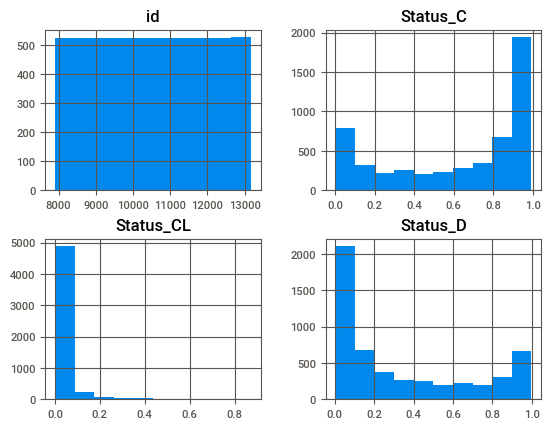

In [51]:
df_sub.hist()

In [52]:
df_sub

,id,Status_C,Status_CL,Status_D
0,7905,0.50,0.03,0.47
1,7906,0.48,0.36,0.15
2,7907,0.03,0.02,0.95
3,7908,0.95,0.00,0.05
4,7909,0.86,0.04,0.10
...,...,...,...,...
5266,13171,0.88,0.07,0.06
5267,13172,0.97,0.00,0.02
5268,13173,0.91,0.01,0.08
5269,13174,0.98,0.00,0.01


In [53]:
pd.read_csv("/kaggle/input/playground-series-s3e26/sample_submission.csv")

,id,Status_C,Status_CL,Status_D
0,7905,0.63,0.03,0.34
1,7906,0.63,0.03,0.34
2,7907,0.63,0.03,0.34
3,7908,0.63,0.03,0.34
4,7909,0.63,0.03,0.34
...,...,...,...,...
5266,13171,0.63,0.03,0.34
5267,13172,0.63,0.03,0.34
5268,13173,0.63,0.03,0.34
5269,13174,0.63,0.03,0.34


In [54]:
df_sub.to_csv('submission.csv',index=False)